<a href="https://colab.research.google.com/github/lorenzotagliapietra/ML_project_Tagliapietra/blob/main/Cluster_finder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:

"""
# Clustering di Galassie in Diagramma Colore-Magnitudine

Questo notebook implementa una pipeline per identificare galassie compagne attorno a una radiogalassia centrale utilizzando metodi di clustering non supervisionato nel diagramma colore-magnitudine (CMD).
"""

import numpy as np
import pandas as pd
!pip install matplotlib==3.10.0
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns
from astropy.stats import sigma_clip
from astropy.io import fits

from sklearn.preprocessing import StandardScaler
from matplotlib.colors import to_rgba

!pip install adjustText
from adjustText import adjust_text

# Configurazione grafica
try:
    plt.style.use('seaborn-v0_8')  # Prova con il nuovo nome dello stile
except:
    plt.style.use('ggplot')  # Fallback a un altro stile disponibile
sns.set_palette("colorblind")
%matplotlib inline


In [3]:
"""
## 1. Caricamento e Preparazione dei Dati

Carichiamo i tre cataloghi disponibili:
1. Tutti gli oggetti nel campo
2. Solo oggetti classificati come galassie
3. Solo galassie ellittiche
"""

from google.colab import drive
drive.mount('/content/drive')

# Funzione per filtrare gli oggetti con errori < 20% del valore della magnitudine
def filter_by_mag_errors(df):
    # Verifica che le colonne necessarie esistano
    required_cols = ['imag', 'e_imag', 'rmag', 'e_rmag']
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"Il DataFrame deve contenere le colonne: {required_cols}")

    # Calcola gli errori relativi
    imag_error_ratio = df['e_imag'] / df['imag']
    rmag_error_ratio = df['e_rmag'] / df['rmag']
    r_i = df['rmag'] - df['imag']

    # Filtra gli oggetti con errori < 20%
    filtered = df[(imag_error_ratio < 0.2) & (rmag_error_ratio < 0.2) & (r_i < 3.0) & (r_i > -3.0)]

    print(f"Filtrati {len(df) - len(filtered)} oggetti ({(len(df) - len(filtered))/len(df)*100:.1f}%) con errori > 20% o colori estremi")
    return filtered

# Caricamento dei dati
def load_fits_to_dataframe(file_path):
    with fits.open(file_path) as hdul:
        data = hdul[1].data  # Assumendo che i dati siano nella prima estensione
        return pd.DataFrame(data)

# Carica e filtra i dati
print("Caricamento e filtraggio dei dati...")
all_objects = load_fits_to_dataframe('/content/drive/MyDrive/environment_redsequence/J082729_73/crossSDSSJ082729.73+530733.4.fits')
all_objects = filter_by_mag_errors(all_objects)

galaxies = load_fits_to_dataframe('/content/drive/MyDrive/environment_redsequence/J082729_73/galaxiesSDSSJ082729.73+530733.4.fits')
galaxies = filter_by_mag_errors(galaxies)

ellipticals = load_fits_to_dataframe('/content/drive/MyDrive/environment_redsequence/J082729_73/ellipSDSSJ082729.73+530733.4.fits')
ellipticals = filter_by_mag_errors(ellipticals)

# Visualizziamo la struttura dei dati filtrati
print("\nTutti gli oggetti (filtrati):")
display(all_objects.head())
print(f"Numero totale: {len(all_objects)}")

print("\nGalassie (filtrate):")
display(galaxies.head())
print(f"Numero totale: {len(galaxies)}")

print("\nGalassie ellittiche (filtrate):")
display(ellipticals.head())
print(f"Numero totale: {len(ellipticals)}")


Mounted at /content/drive
Caricamento e filtraggio dei dati...
Filtrati 10 oggetti (0.3%) con errori > 20% o colori estremi
Filtrati 2 oggetti (0.2%) con errori > 20% o colori estremi
Filtrati 0 oggetti (0.0%) con errori > 20% o colori estremi

Tutti gli oggetti (filtrati):


name   zsrc          ra        dec  kpcscale  \
0  SDSSJ082729.73+530733.4  0.119  126.873875  53.125944  2.162679   
1  SDSSJ082729.73+530733.4  0.119  126.873875  53.125944  2.162679   
2  SDSSJ082729.73+530733.4  0.119  126.873875  53.125944  2.162679   
3  SDSSJ082729.73+530733.4  0.119  126.873875  53.125944  2.162679   
4  SDSSJ082729.73+530733.4  0.119  126.873875  53.125944  2.162679   

         R500       R2000  R2000deg                SDSS9     RAJ2000  ...  \
0  231.194714  924.778858  0.256883  J082547.61+530805.8  126.448409  ...   
1  231.194714  924.778858  0.256883  J082548.34+530526.2  126.451420  ...   
2  231.194714  924.778858  0.256883  J082548.36+530716.5  126.451524  ...   
3  231.194714  924.778858  0.256883  J082548.47+530703.1  126.451961  ...   
4  231.194714  924.778858  0.256883  J082548.73+530603.3  126.453070  ...   

     e_zsp  f_zsp  spType    spCl     subClass       Vdisp    e_Vdisp  \
0      NaN -32768                                      NaN        NaN   
1      NaN -32768                                      NaN        NaN   
2      NaN -32768                                      NaN        NaN   
3  0.00031      4  LRG     GALAXY               263.399994  91.800003   
4      NaN -32768                                      NaN        NaN   

       angsep        dproj       dz  
0  919.568918  1988.732571      NaN  
1  921.782874  1993.520647      NaN  
2  912.569428  1973.594920      NaN  
3  912.013908  1972.393508  0.58063  
4  913.738567  1976.123393      NaN  

[5 rows x 38 columns]

Numero totale: 3055

Galassie (filtrate):


name   zsrc          ra        dec  kpcscale  \
0  SDSSJ082729.73+530733.4  0.119  126.873875  53.125944  2.162679   
1  SDSSJ082729.73+530733.4  0.119  126.873875  53.125944  2.162679   
2  SDSSJ082729.73+530733.4  0.119  126.873875  53.125944  2.162679   
3  SDSSJ082729.73+530733.4  0.119  126.873875  53.125944  2.162679   
4  SDSSJ082729.73+530733.4  0.119  126.873875  53.125944  2.162679   

         R500       R2000  R2000deg                SDSS9     RAJ2000  ...  \
0  231.194714  924.778858  0.256883  J082548.36+530716.5  126.451524  ...   
1  231.194714  924.778858  0.256883  J082549.42+530604.7  126.455922  ...   
2  231.194714  924.778858  0.256883  J082550.29+530810.7  126.459555  ...   
3  231.194714  924.778858  0.256883  J082550.55+530612.5  126.460637  ...   
4  231.194714  924.778858  0.256883  J082550.58+530919.4  126.460778  ...   

       angsep        dproj    gmz    umr    gmr    rmi        xs        ys  \
0  912.569428  1973.594920  1.492  1.942  1.384  0.464 -0.253463 -0.003921   
1  907.465594  1962.556964  0.692  1.276  0.461  0.252 -0.250940 -0.023899   
2  895.686126  1937.081755  0.818  2.273  0.748  0.292 -0.248556  0.011084   
3  896.563282  1938.978761  1.618  1.708  1.103  0.194 -0.248097 -0.021737   
4  898.354901  1942.853458  2.180  0.775  1.473  0.146 -0.247712  0.030184   

        euclD   dz  
0  912.575382  0.0  
1  907.471449  0.0  
2  895.691756  0.0  
3  896.568928  0.0  
4  898.360581  0.0  

[5 rows x 39 columns]

Numero totale: 819

Galassie ellittiche (filtrate):


col1                     name   zsrc          ra        dec  kpcscale  \
0   230  SDSSJ082729.73+530733.4  0.119  126.873875  53.125944  2.162679   
1   101  SDSSJ082729.73+530733.4  0.119  126.873875  53.125944  2.162679   
2   124  SDSSJ082729.73+530733.4  0.119  126.873875  53.125944  2.162679   
3   133  SDSSJ082729.73+530733.4  0.119  126.873875  53.125944  2.162679   
4   137  SDSSJ082729.73+530733.4  0.119  126.873875  53.125944  2.162679   

         R500       R2000  R2000deg                SDSS9  ...      angsep  \
0  231.194714  924.778858  0.256883  J082708.39+530915.2  ...  217.328690   
1  231.194714  924.778858  0.256883  J082628.40+531706.0  ...  794.721288   
2  231.194714  924.778858  0.256883  J082635.52+531317.8  ...  596.772939   
3  231.194714  924.778858  0.256883  J082638.81+531415.6  ...  609.309779   
4  231.194714  924.778858  0.256883  J082639.43+531330.5  ...  576.193538   

         dproj    gmz    umr    gmr    rmi        xs        ys       euclD  \
0   470.012237  1.555  2.704  0.656  0.251 -0.053306  0.028335  217.328770   
1  1718.727199  1.911  3.209  1.077  0.454 -0.152773  0.159355  794.725220   
2  1290.628422  1.871  3.002  1.048  0.478 -0.135226  0.095885  596.774604   
3  1317.741585  1.766  3.142  0.993  0.466 -0.126974  0.111912  609.311551   
4  1246.121780  1.891  3.074  1.056  0.474 -0.125453  0.099392  576.195037   

        dz  
0  0.00000  
1  0.00000  
2 -0.00088  
3  0.00000  
4  0.00000  

[5 rows x 40 columns]

Numero totale: 38


In [4]:
# Identificazione dell'oggetto target (minima separazione angolare presente in tutti e 3 i cataloghi)
def find_target(all_objects, galaxies, ellipticals):
    """Trova l'oggetto con minima separazione angolare presente in tutti e 3 i cataloghi"""
    # Trova gli ID comuni
    common_ids = set(all_objects['SDSS9']).intersection(set(galaxies['SDSS9'])).intersection(set(ellipticals['SDSS9']))

    # Filtra gli oggetti comuni
    common_all = all_objects[all_objects['SDSS9'].isin(common_ids)]
    common_gal = galaxies[galaxies['SDSS9'].isin(common_ids)]
    common_ell = ellipticals[ellipticals['SDSS9'].isin(common_ids)]

    # Trova quello con minima angsep (assumendo che la colonna esista)
    target = common_all.loc[common_all['angsep'].idxmin()]

    return target

# Trova e mostra l'oggetto target
target = find_target(all_objects, galaxies, ellipticals)
print("\nOggetto target identificato:")
print(f"ID: {target['SDSS9']}, angsep: {target['angsep']:.4f}")
print(f"Coordinate: RA={target['RAJ2000']}, DEC={target['DEJ2000']}")
print(f"Magnitudini: r={target['rmag']:.2f}, i={target['imag']:.2f}")



Oggetto target identificato:
ID: J082723.61+530834.4, angsep: 82.1773
Coordinate: RA=126.848389, DEC=53.142894
Magnitudini: r=17.61, i=17.09


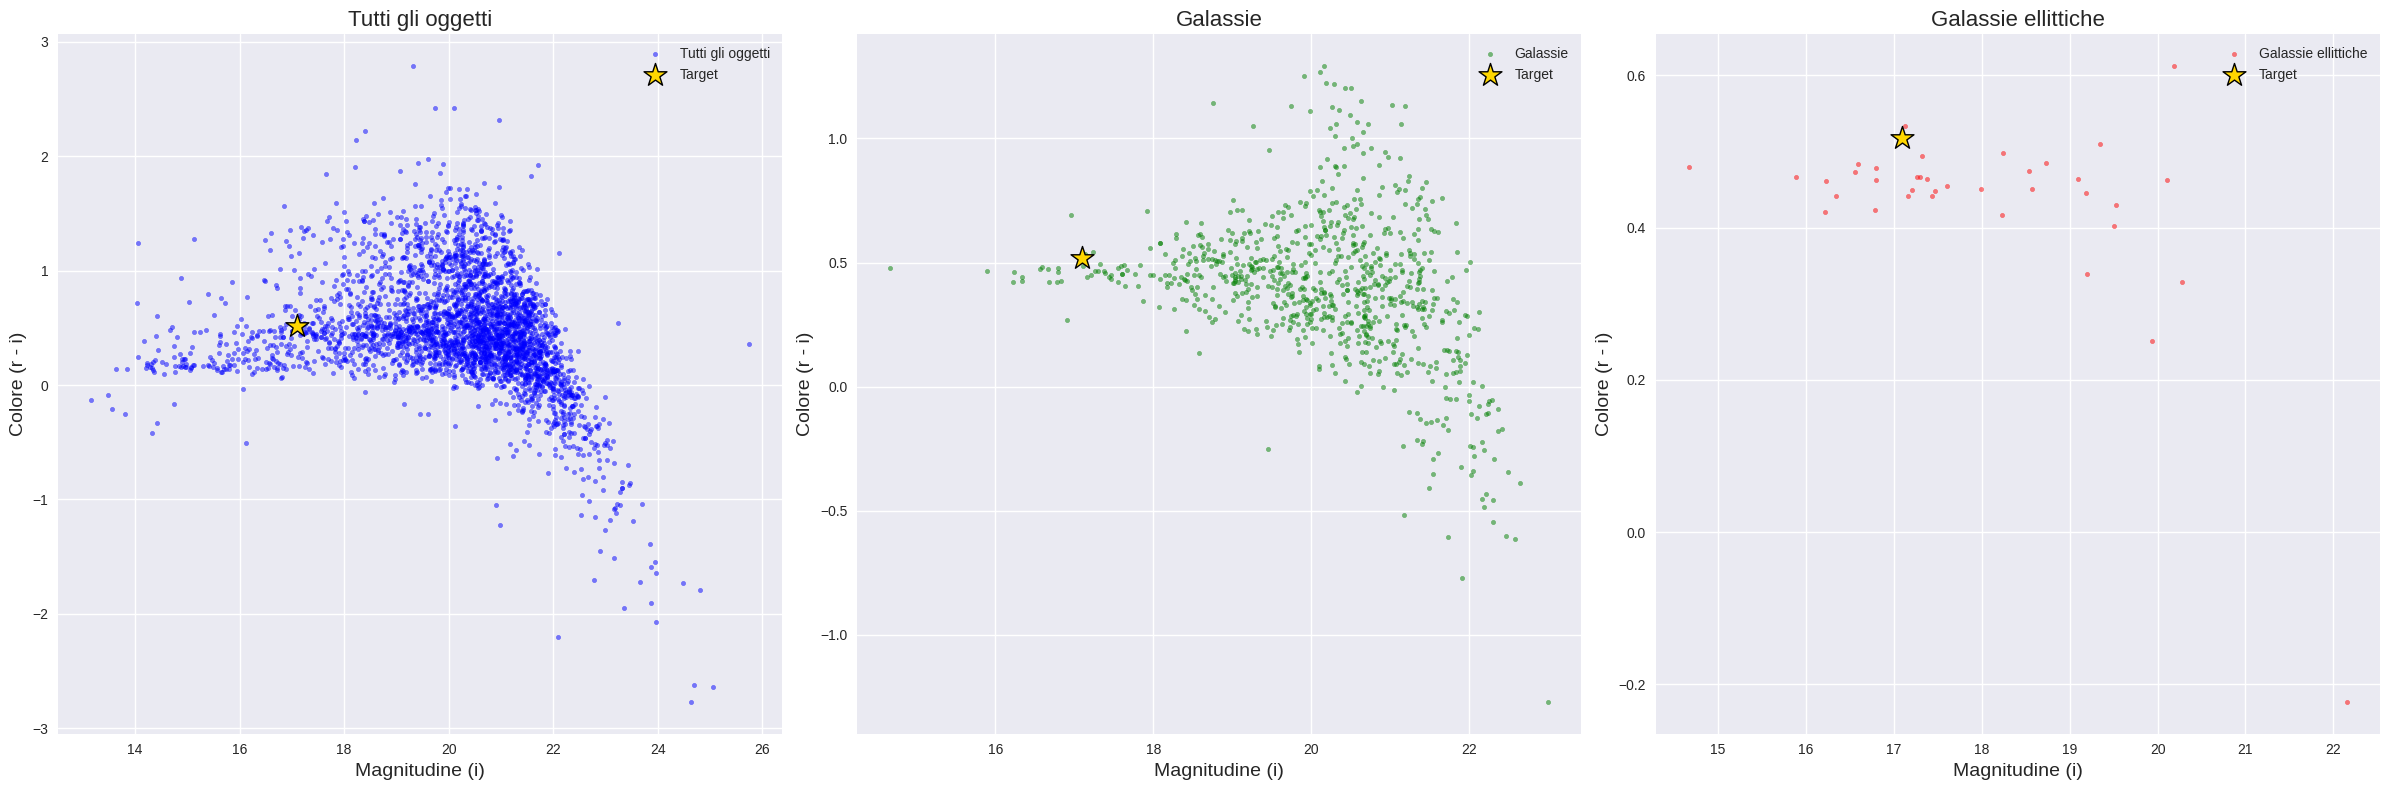

In [26]:
"""
## 2. Diagramma Colore-Magnitudine (CMD)

Creiamo il diagramma colore-magnitudine utilizzando le bande r e i:
- Asse X: magnitudine (i)
- Asse Y: colore (r - i)
"""

def plot_cmd(data, title, ax=None, color='b', alpha=0.5, target=None):
    """Plot del diagramma colore-magnitudine"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Plot dei punti principali
    ax.scatter(data['imag'], data['rmag'] - data['imag'],
               c=color, alpha=alpha, s=10, label=title)

    # Aggiungi target se specificato
    if target is not None:
        target_x = target['imag']
        target_y = target['rmag'] - target['imag']
        ax.scatter(target_x, target_y, s=300, marker='*',
                  color='gold', edgecolor='black', linewidth=1,
                  label='Target', zorder=10)

    ax.set_xlabel('Magnitudine (i)', fontsize=14)
    ax.set_ylabel('Colore (r - i)', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.grid(True)

    # Aggiungi legenda se c'è il target
    if target is not None:
        ax.legend()

    return ax

# Plot per i tre cataloghi con target
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
plot_cmd(all_objects, "Tutti gli oggetti", axes[0], color='b', target=target)
plot_cmd(galaxies, "Galassie", axes[1], color='g', target=target)
plot_cmd(ellipticals, "Galassie ellittiche", axes[2], color='r', target=target)
plt.tight_layout()
plt.show()


In [34]:
"""
## 3. Clustering con Gaussian Mixture Models (GMM)

Applichiamo il GMM al diagramma CMD per identificare la red sequence.
"""

def fit_gmm(data, n_components=2, plot=True, target=None, ellipticals=None):
    """Applica GMM ai dati e visualizza i risultati"""
    # Preparazione dei dati
    X = np.column_stack([data['imag'], data['rmag'] - data['imag']])  # i mag su x, (r-i) su y

    # Standardizzazione
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Fit del modello GMM
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(X_scaled)
    labels = gmm.predict(X_scaled)
    probs = gmm.predict_proba(X_scaled)

    # Calcolo di BIC e AIC
    bic = gmm.bic(X_scaled)
    aic = gmm.aic(X_scaled)

    if plot:
        # Plot dei risultati
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        # Scatter plot con colori per cluster

        for i in range(n_components):
            mask = labels == i
            ax1.scatter(X[mask, 0], X[mask, 1], s=10, label=f'Cluster {i}', alpha=0.6)
                    # --- Aggiungi marker '+' per oggetti ellittici (se specificato) ---
        if ellipticals is not None and 'SDSS9' in data.columns and 'SDSS9' in ellipticals.columns:
            common_mask = data['SDSS9'].isin(ellipticals['SDSS9'])
            for i in range(n_components):
                mask = (labels == i) & common_mask
                ax1.scatter(X[mask, 0], X[mask, 1],
                            marker='+', c=f'C{i}', s=60, linewidths=1.5, label=f'Ellittiche Cluster {i}')




        # Aggiungi target al primo plot
        if target is not None:
            target_x = target['imag']
            target_y = target['rmag'] - target['imag']
            ax1.scatter(target_x, target_y, s=300, marker='*',
                       color='gold', edgecolor='black', linewidth=1,
                       label='Target', zorder=10)

        ax1.set_xlabel('Magnitudine (i)', fontsize=14)
        ax1.set_ylabel('Colore (r - i)', fontsize=14)
        ax1.set_title(f'GMM con {n_components} componenti', fontsize=16)
        ax1.legend()
        ax1.grid(True)

        # Plot delle ellissi delle gaussiane
        ax2.scatter(X[:, 0], X[:, 1], s=5, c='gray', alpha=0.3)

        # Aggiungi target al secondo plot
        if target is not None:
            ax2.scatter(target_x, target_y, s=300, marker='*',
                       color='gold', edgecolor='black', linewidth=1,
                       label='Target', zorder=10)

        for i in range(n_components):
            # Converti i parametri della gaussiana alla scala originale
            mean = scaler.inverse_transform(gmm.means_[i].reshape(1, -1)).flatten()
            # Ricostruisci la covarianza nella scala originale (solo se full)
            if gmm.covariance_type == 'full':
              cov_scaled = gmm.covariances_[i]
            # "de-standardizza" la covarianza
              cov = np.diag(scaler.scale_) @ cov_scaled @ np.diag(scaler.scale_)
            else:
              cov = np.eye(2)  # fallback sicuro


            # Calcola autovalori e autovettori per disegnare l'ellisse
            eigenvalues, eigenvectors = np.linalg.eigh(cov)
            eigenvalues = np.where(eigenvalues < 0, 0, eigenvalues)  # Evita NaN/complessi
            angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
            width, height = 2 * np.sqrt(eigenvalues + 1e-8)  # Aggiungi epsilon per sicurezza


            ellipse = Ellipse(mean, width, height, angle=angle,
                             edgecolor='r', facecolor='none', linewidth=2)
            ax2.add_patch(ellipse)
            ax2.scatter(mean[0], mean[1], c='k', marker='x', s=100)

        ax2.set_xlabel('Magnitudine (i)', fontsize=14)
        ax2.set_ylabel('Colore (r - i)', fontsize=14)
        ax2.set_title(f'Contorni delle gaussiane', fontsize=16)
        ax2.legend()  # Mostra legenda solo se c'è il target
        ax2.grid(True)

        plt.show()

    return gmm, labels, probs, bic, aic


Usiamo tutti gli oggetti del campo


GMM con 2 componenti:


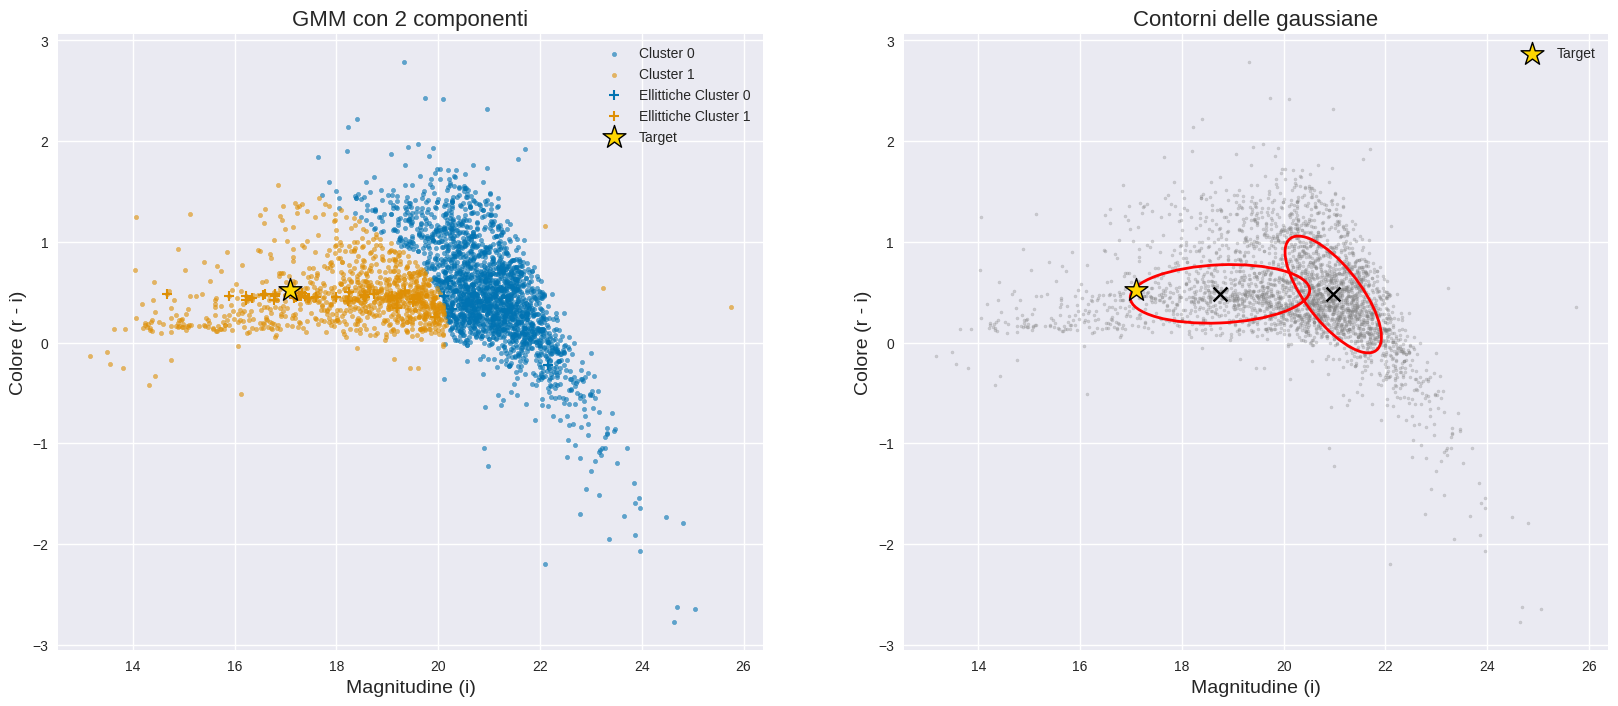


GMM con 3 componenti:


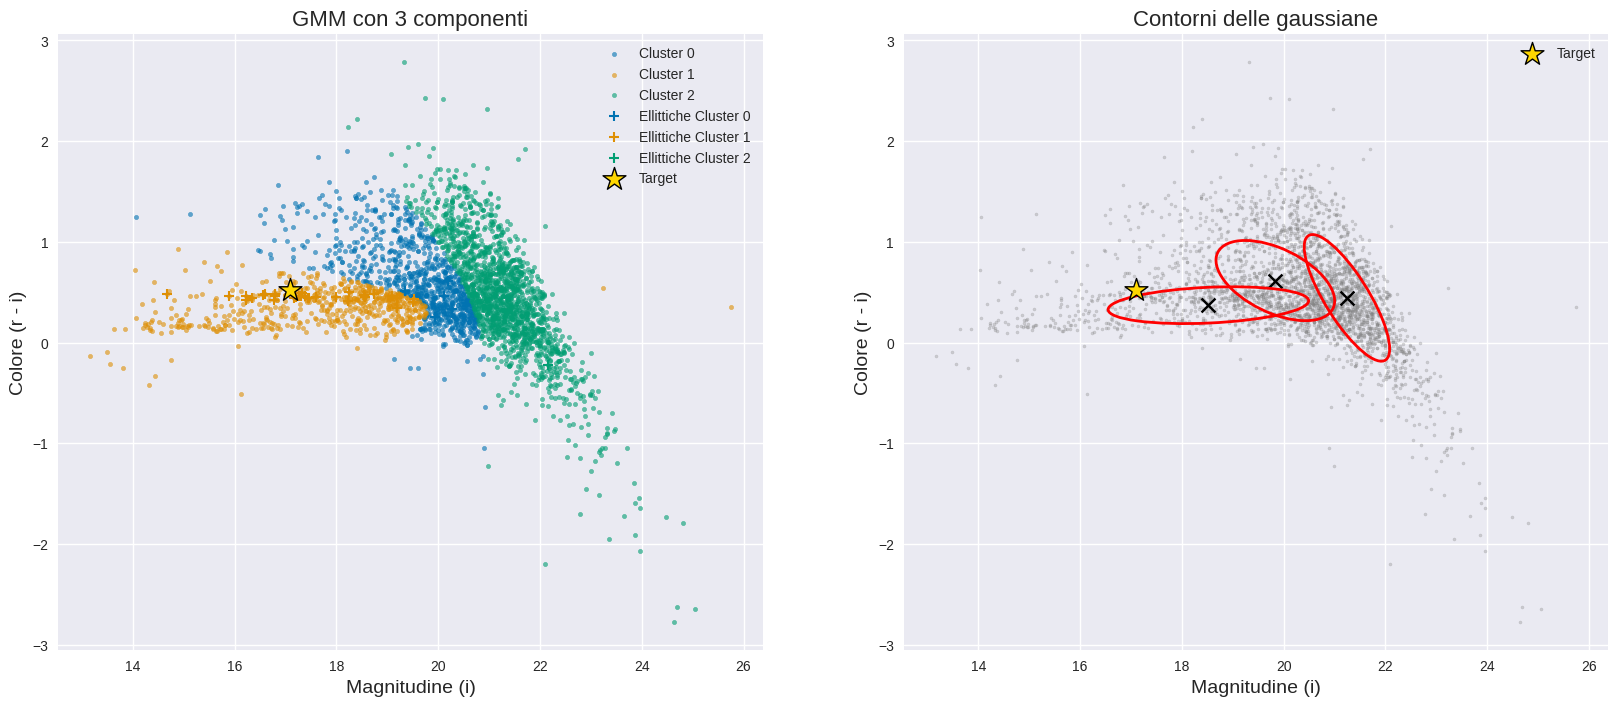


GMM con 4 componenti:


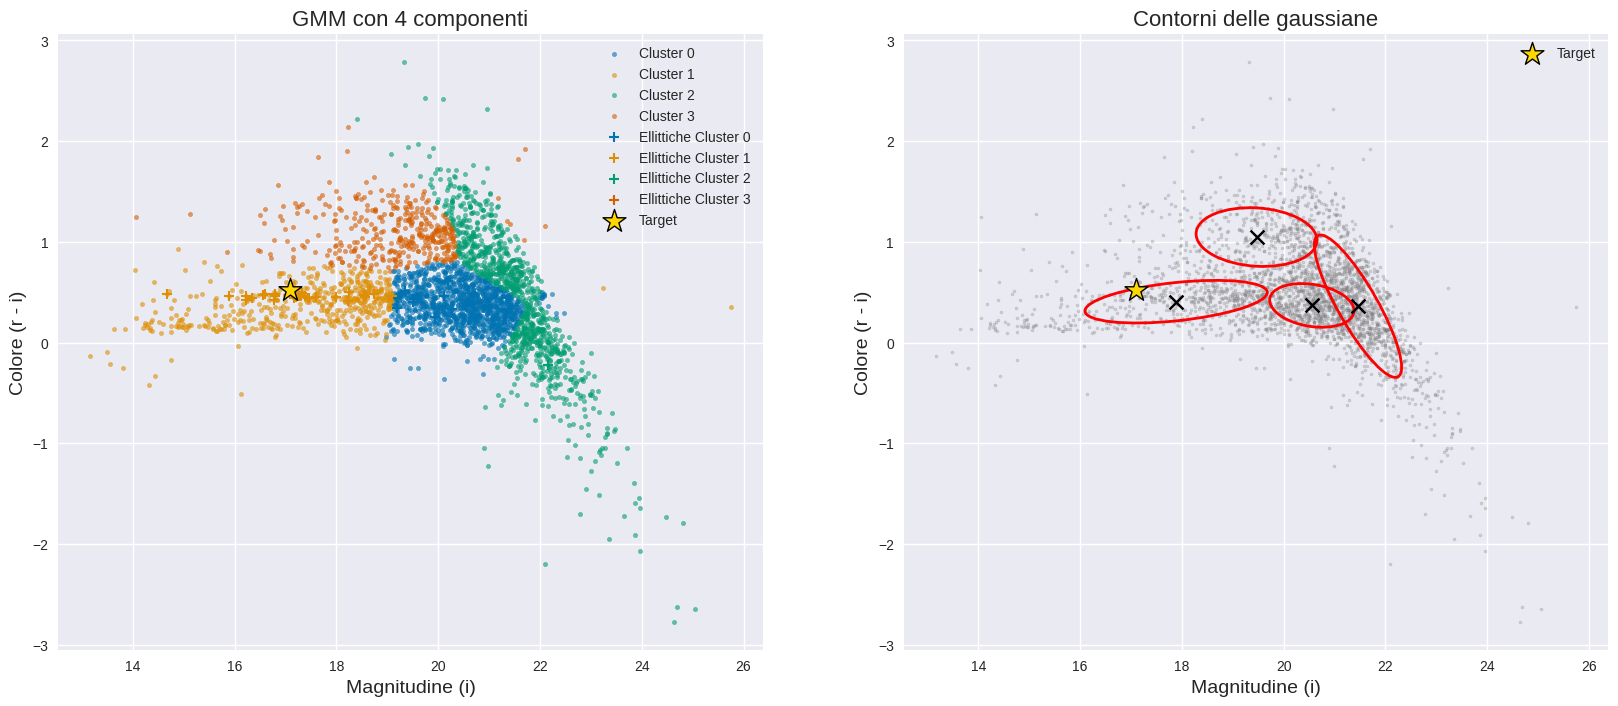


GMM con 5 componenti:


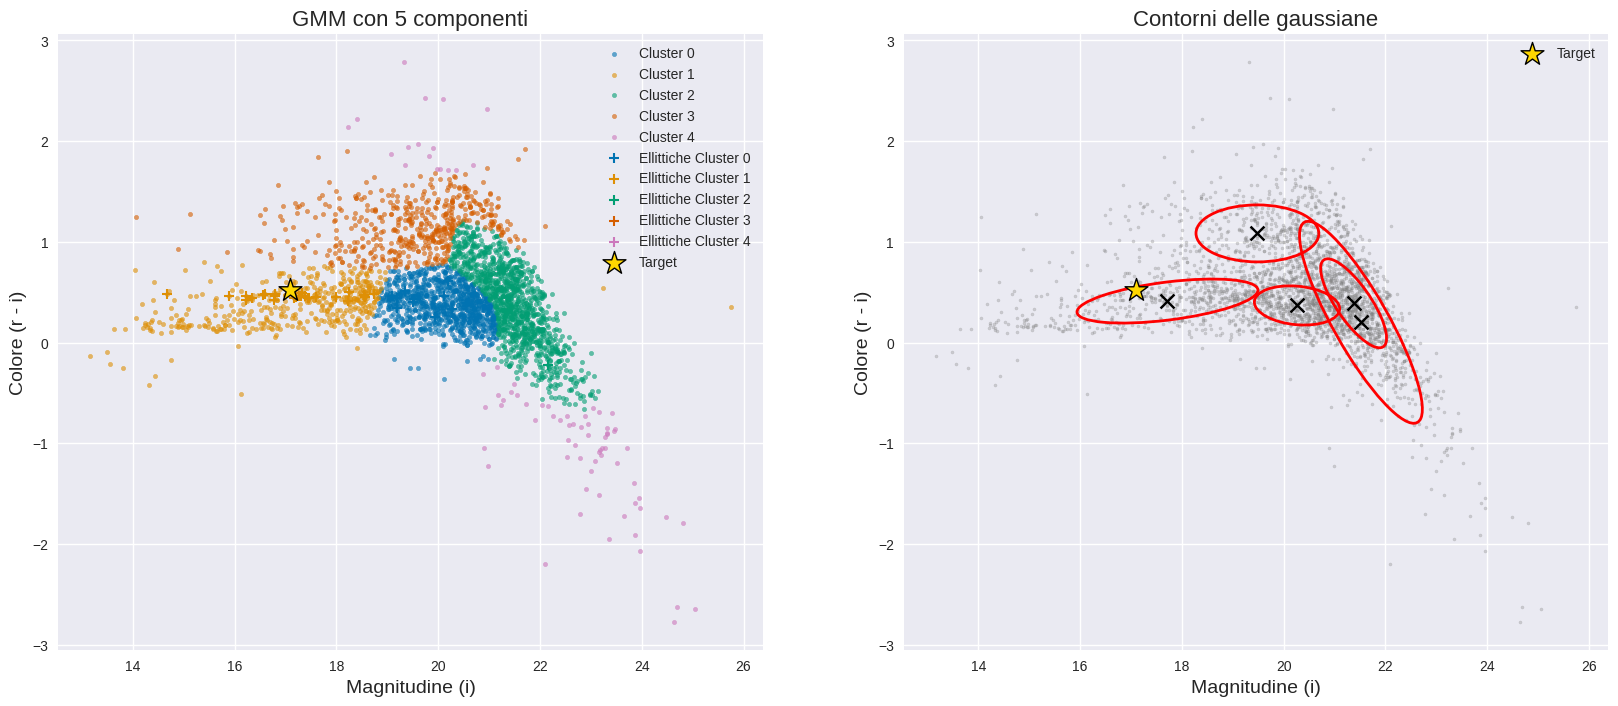


GMM con 6 componenti:


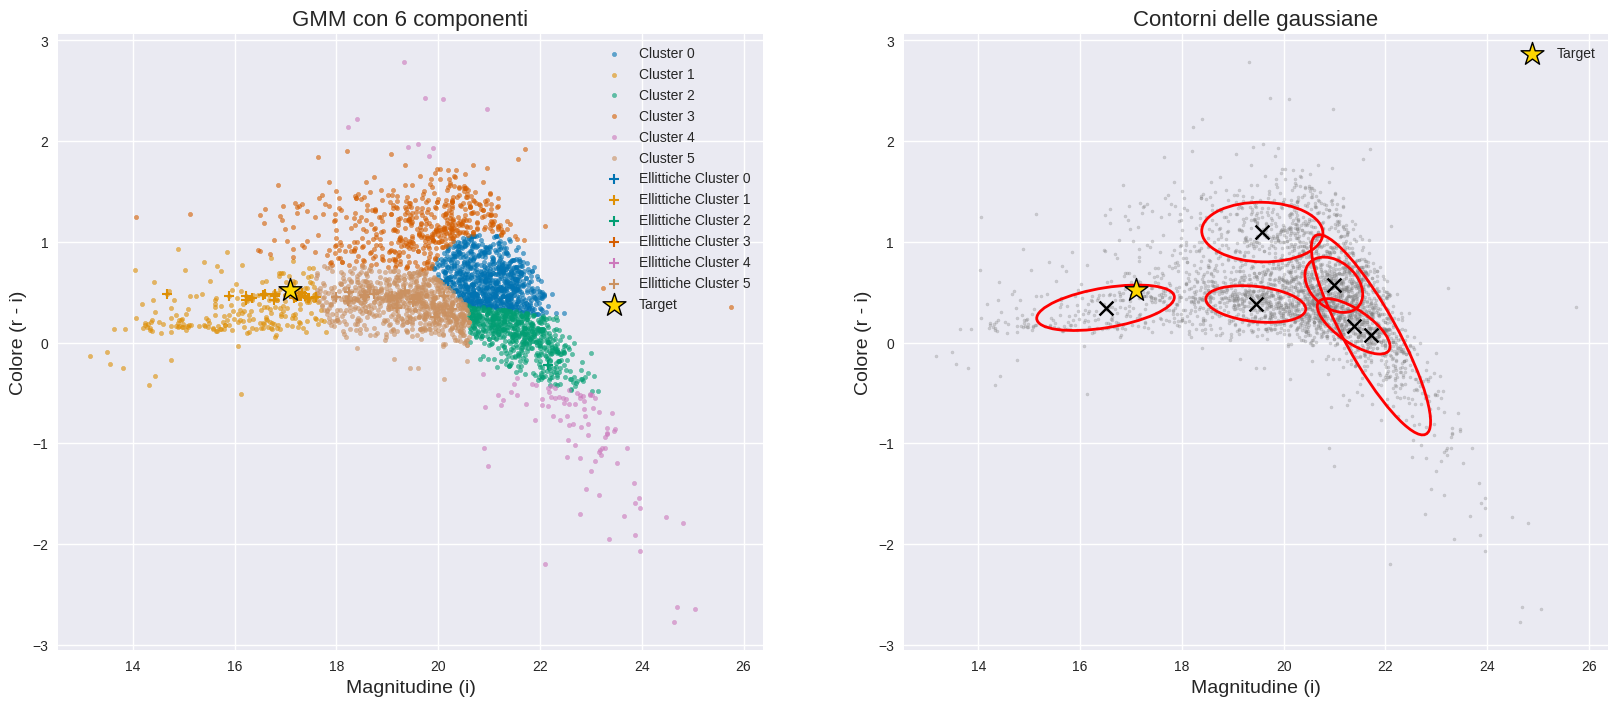


GMM con 7 componenti:


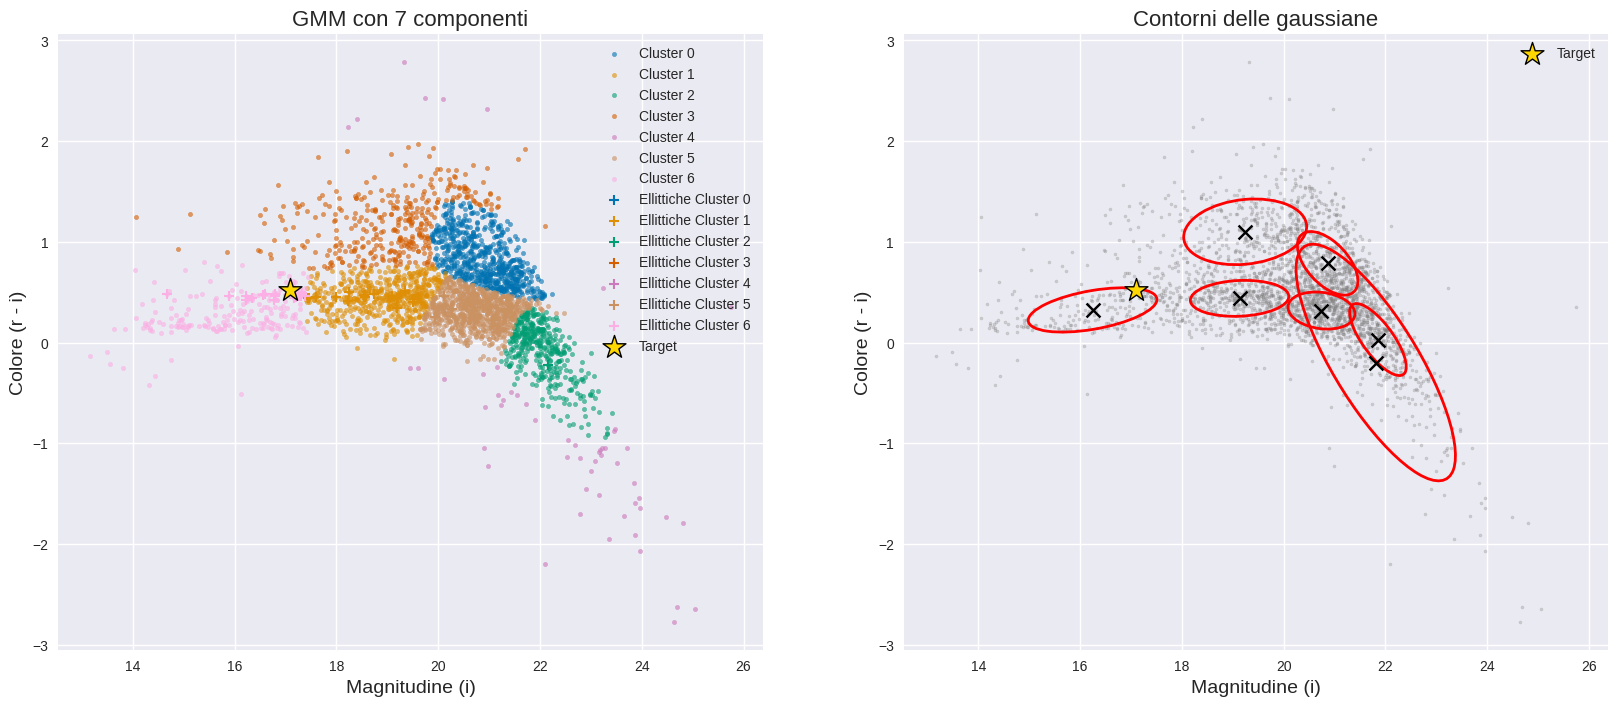


GMM con 8 componenti:


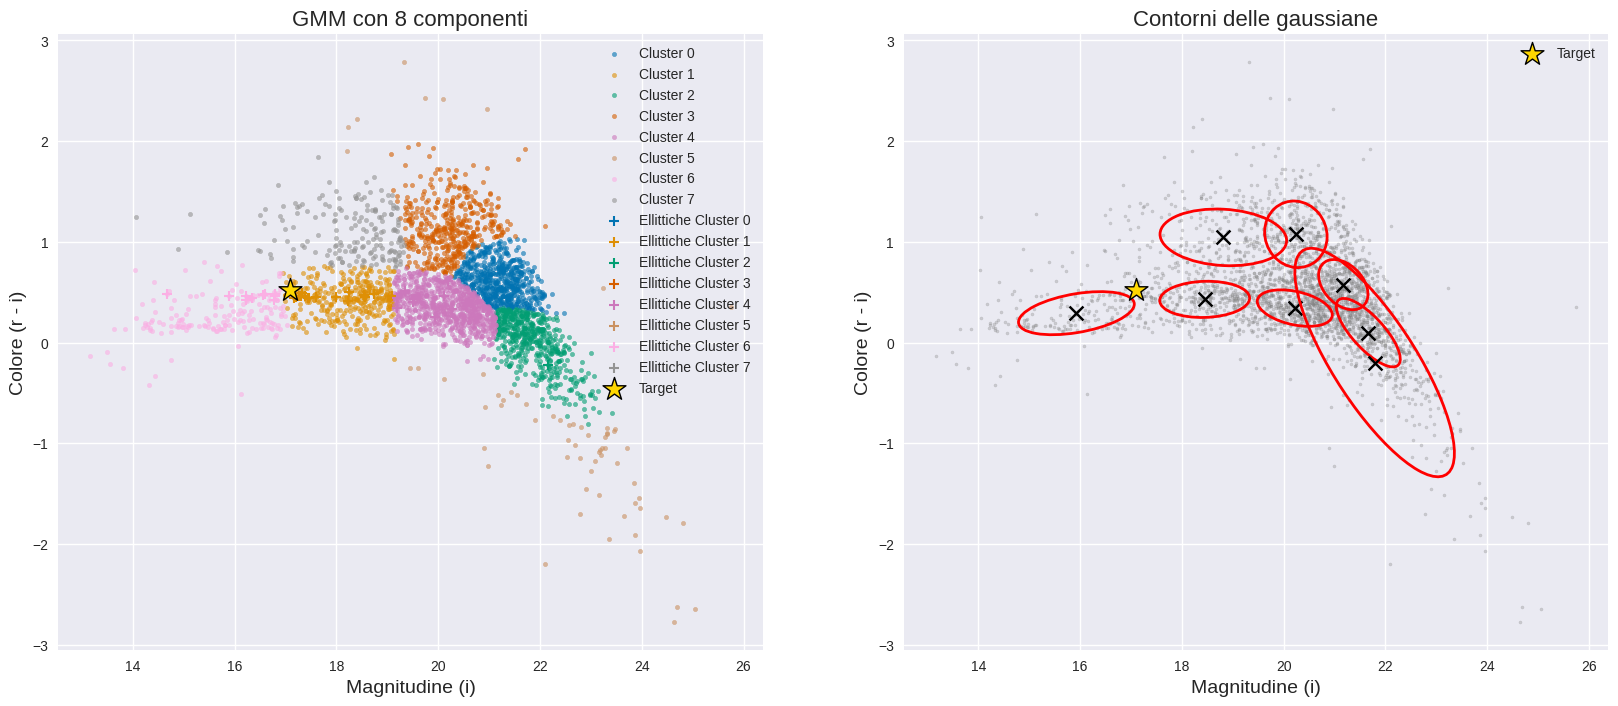


GMM con 9 componenti:


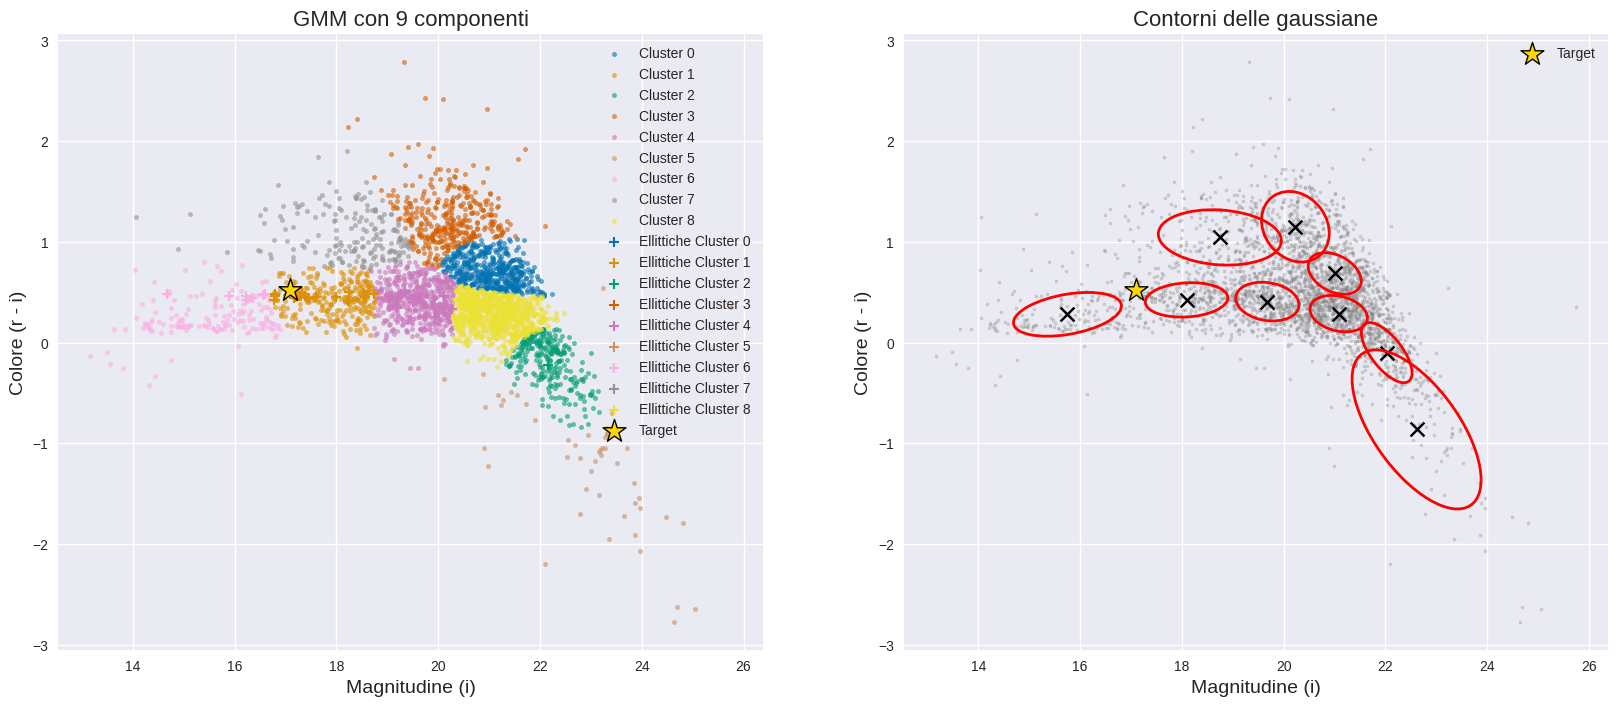

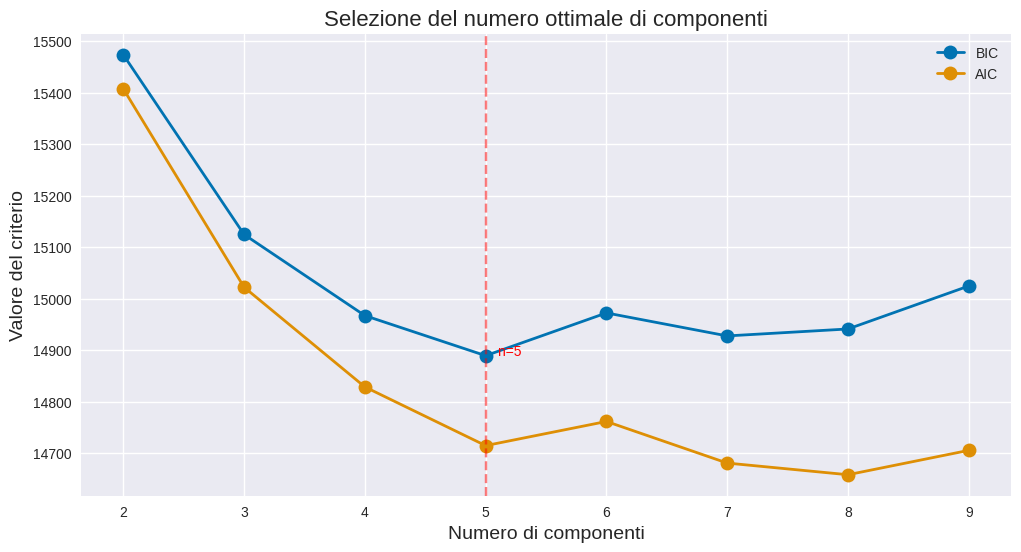


Numero ottimale di componenti (basato su BIC): 5


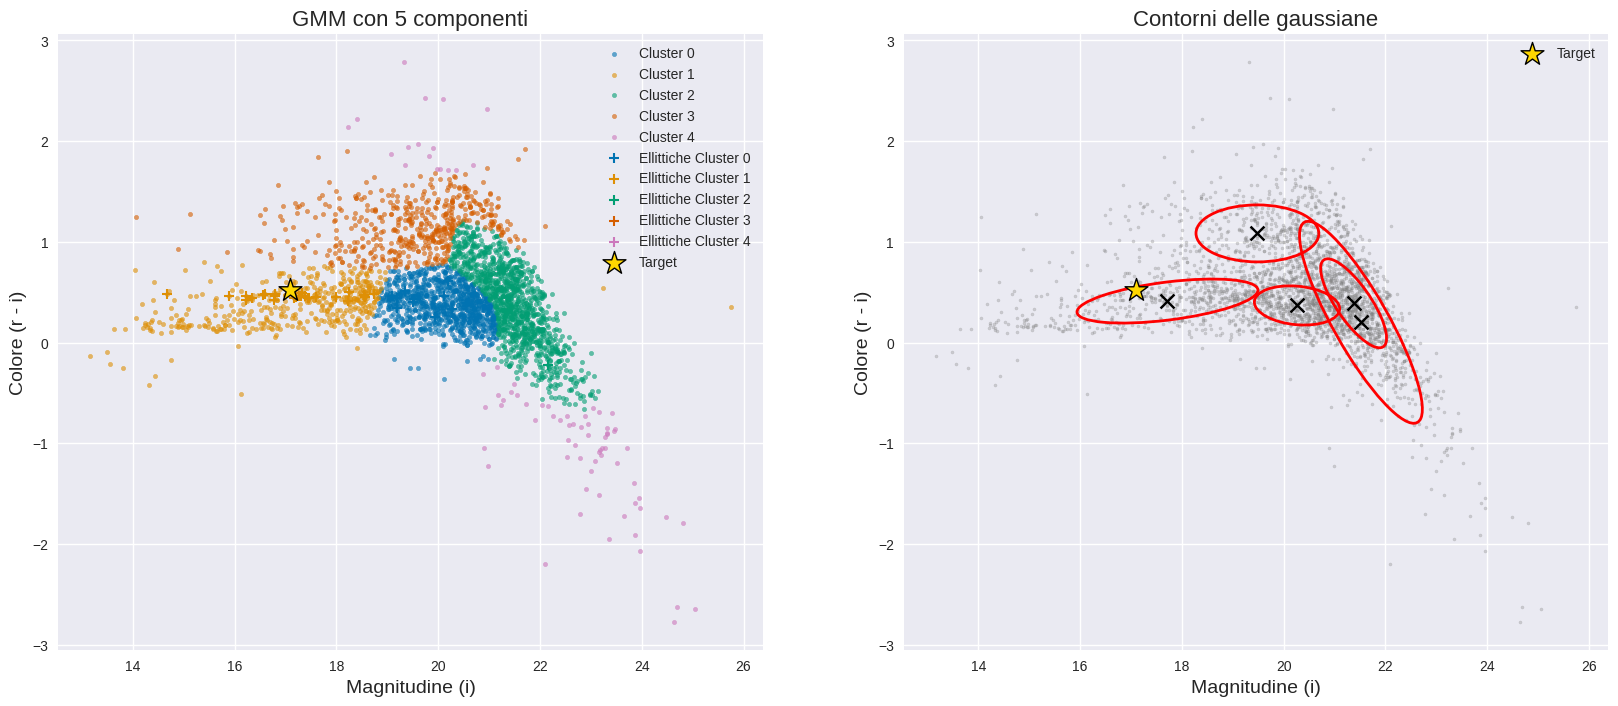


Statistiche del cluster:
- Numero membri: 350/3055
- Frazione: 11.46%
- Colore medio (r-i): 0.34
- Magnitudine media (i): 16.77

Componente selezionata (contiene il target):
- Indice componente: 1
- Media colore (r-i): -1.41
- Media magnitudine (i): -0.14


In [35]:
# Applica GMM con diversi numeri di componenti
n_components_range = range(2, 10)
bics, aics = [], []

# Prima filtraggio dei dati per evitare warning
clean_obj = all_objects[
    (all_objects['imag'].notna()) &
    (all_objects['rmag'].notna()) &
    (all_objects['imag'] > 0) &
    (all_objects['rmag'] > 0)
].copy()

# Ricrea X usato nel fit
X = np.column_stack([
    clean_obj['imag'],
    clean_obj['rmag'] - clean_obj['imag']
])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Trasforma anche il target nello stesso spazio
target_X = np.array([[target['imag'], target['rmag'] - target['imag']]])
target_X_scaled = scaler.transform(target_X)


for n in n_components_range:
    print(f"\nGMM con {n} componenti:")
    try:
        gmm, labels, probs, bic, aic = fit_gmm(clean_obj, n_components=n, target=target, ellipticals=ellipticals)
        bics.append(bic)
        aics.append(aic)
    except Exception as e:
        print(f"Errore con {n} componenti: {str(e)}")
        bics.append(np.inf)
        aics.append(np.inf)

# Plot migliorato di BIC e AIC
plt.figure(figsize=(12, 6))
plt.plot(n_components_range, bics, 'o-', label='BIC', linewidth=2, markersize=10)
plt.plot(n_components_range, aics, 'o-', label='AIC', linewidth=2, markersize=10)

# Evidenzia il minimo per BIC
best_n_bic = n_components_range[np.argmin(bics)]
plt.axvline(x=best_n_bic, color='r', linestyle='--', alpha=0.5)
plt.text(best_n_bic+0.1, np.min(bics), f'n={best_n_bic}', color='r')

plt.xlabel('Numero di componenti', fontsize=14)
plt.ylabel('Valore del criterio', fontsize=14)
plt.title('Selezione del numero ottimale di componenti', fontsize=16)
plt.xticks(n_components_range)
plt.legend()
plt.grid(True)
plt.show()

# Selezione del modello migliore (BIC più basso)
best_n = best_n_bic
print(f"\nNumero ottimale di componenti (basato su BIC): {best_n}")



# Fit del modello finale con controllo robusto
try:
    final_gmm, final_labels, final_probs, _, _ = fit_gmm(
        clean_obj,
        n_components=best_n,
        target=target,
        ellipticals=ellipticals
    )

    # Identifica la componente che contiene l'oggetto target
    # Prima troviamo l'indice del target nel dataframe clean_galaxies
    target_idx = clean_obj[clean_obj['SDSS9'] == target['SDSS9']].index[0]
    # Poi troviamo la componente a cui appartiene (quella con probabilità massima)
    # Calcola le probabilità del target usando il GMM
    target_probs = final_gmm.predict_proba(target_X_scaled)
    red_sequence_idx = np.argmax(target_probs[0])


    # Seleziona membri con probabilità > 0.7 e statistiche
    cluster_mask = final_probs[:, red_sequence_idx] > 0.7
    cluster_members = clean_obj[cluster_mask]

    print("\nStatistiche del cluster:")
    print(f"- Numero membri: {len(cluster_members)}/{len(clean_obj)}")
    print(f"- Frazione: {len(cluster_members)/len(clean_obj):.2%}")
    print(f"- Colore medio (r-i): {np.mean(cluster_members['rmag'] - cluster_members['imag']):.2f}")
    print(f"- Magnitudine media (i): {np.mean(cluster_members['imag']):.2f}")

    # Aggiungi informazioni sulla componente selezionata
    print(f"\nComponente selezionata (contiene il target):")
    print(f"- Indice componente: {red_sequence_idx}")
    print(f"- Media colore (r-i): {final_gmm.means_[red_sequence_idx, 0]:.2f}")
    print(f"- Media magnitudine (i): {final_gmm.means_[red_sequence_idx, 1]:.2f}")

except Exception as e:
    print(f"\nErrore nel fitting finale: {str(e)}")
    print("Consigli:")
    print("- Verifica la distribuzione dei dati")
    print("- Prova a standardizzare manualmente le features")
    print("- Considera meno componenti se il modello è troppo complesso")

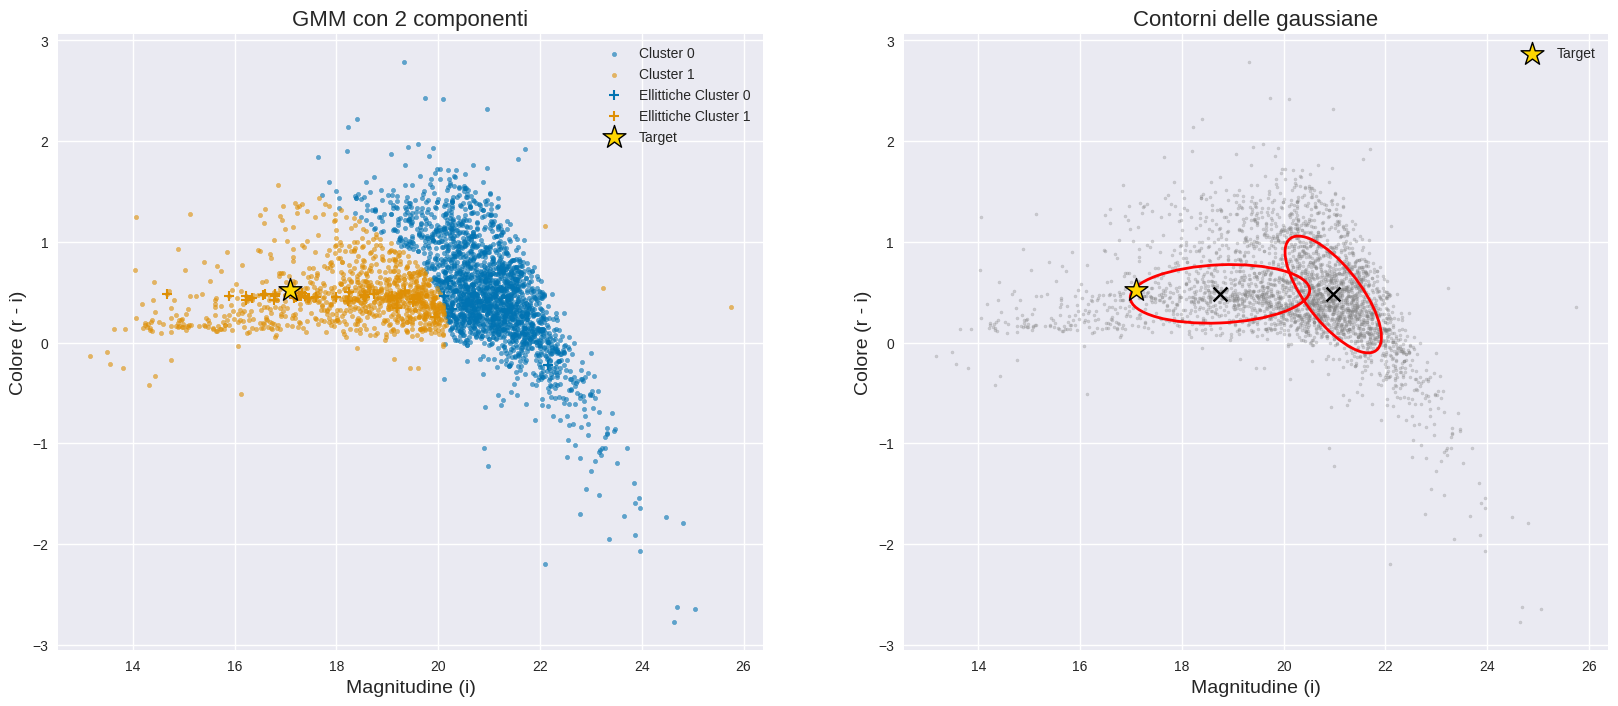


Numero di membri del cluster con GMM a 2 componenti: 832


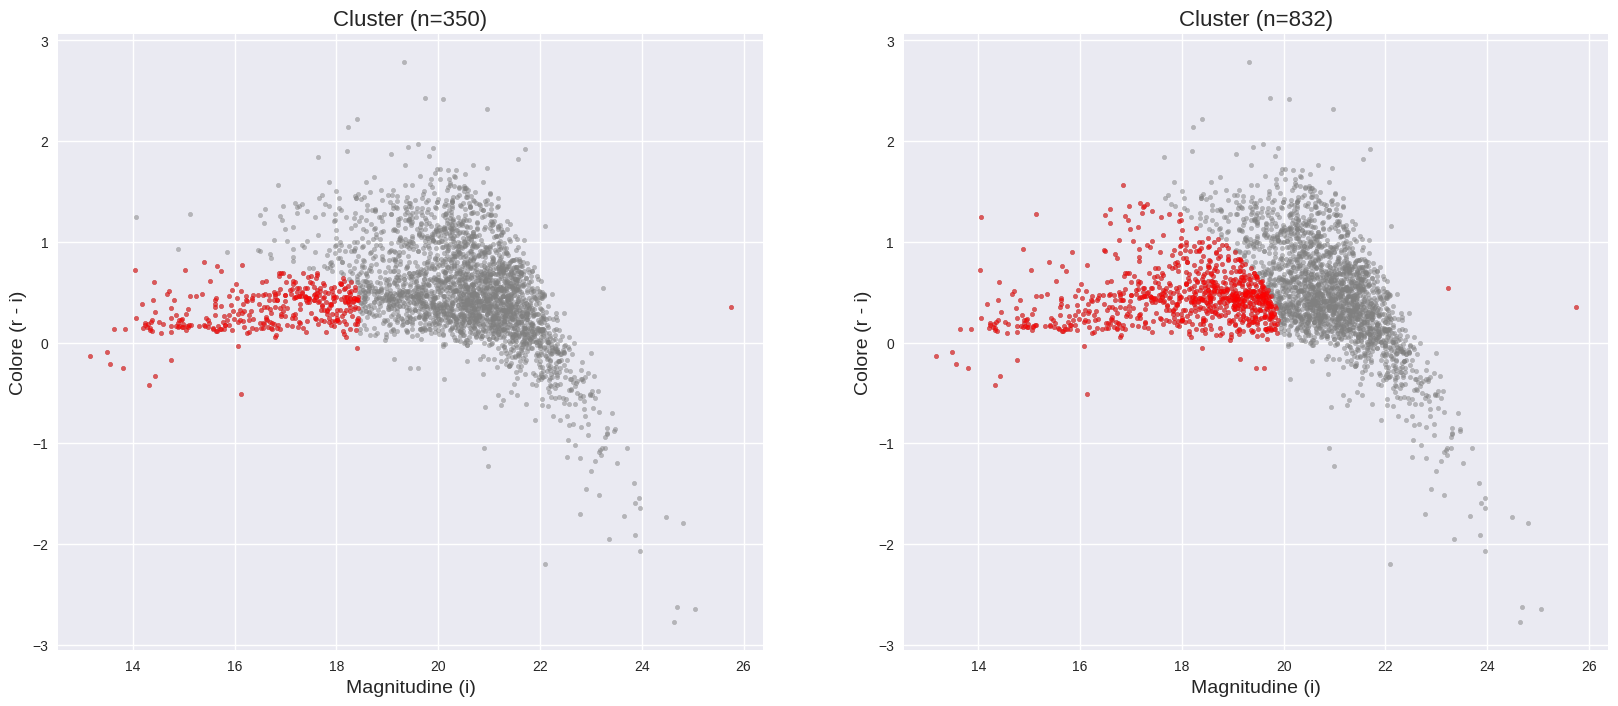

In [36]:
"""
## 4. Confronto: GMM a 2 componenti

Testiamo anche un modello più semplice con solo 2 componenti per confronto.
"""

# Fit del modello a 2 componenti
gmm_2, labels_2, probs_2, _, _ = fit_gmm(all_objects, n_components=2, target=target, ellipticals=ellipticals)

# Ricrea le feature usate nel GMM
X = np.column_stack([
    all_objects['imag'],
    all_objects['rmag'] - all_objects['imag']
])

# Standardizza come nel fit_gmm
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Prepara e standardizza anche il target
target_X = np.array([[target['imag'], target['rmag'] - target['imag']]])
target_X_scaled = scaler.transform(target_X)

# Calcola le probabilità del target
target_probs_2 = gmm_2.predict_proba(target_X_scaled)
red_sequence_idx_2 = np.argmax(target_probs_2[0])


# Seleziona membri del cluster
cluster_mask_2 = probs_2[:, red_sequence_idx_2] > 0.7
cluster_members_2 = all_objects[cluster_mask_2]

print(f"\nNumero di membri del cluster con GMM a 2 componenti: {len(cluster_members_2)}")

# Confronto visivo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot del modello ottimale
plot_cmd(all_objects, "GMM ottimale", ax1, color='gray')
plot_cmd(cluster_members, f"Cluster (n={len(cluster_members)})", ax1, color='red')

# Plot del modello a 2 componenti
plot_cmd(all_objects, "GMM a 2 componenti", ax2, color='gray')
plot_cmd(cluster_members_2, f"Cluster (n={len(cluster_members_2)})", ax2, color='red')

plt.show()


Cluster del target: 31
→ Numero membri nel cluster del target: 199
→ Ellittiche nel cluster del target: 11
Cluster con almeno un'ellittica (escluso il target): [np.int64(10), np.int64(22), np.int64(28), np.int64(33), np.int64(36), np.int64(38), np.int64(44), np.int64(50), np.int64(66), np.int64(74), np.int64(80), np.int64(106), np.int64(117), np.int64(120), np.int64(122), np.int64(144)]


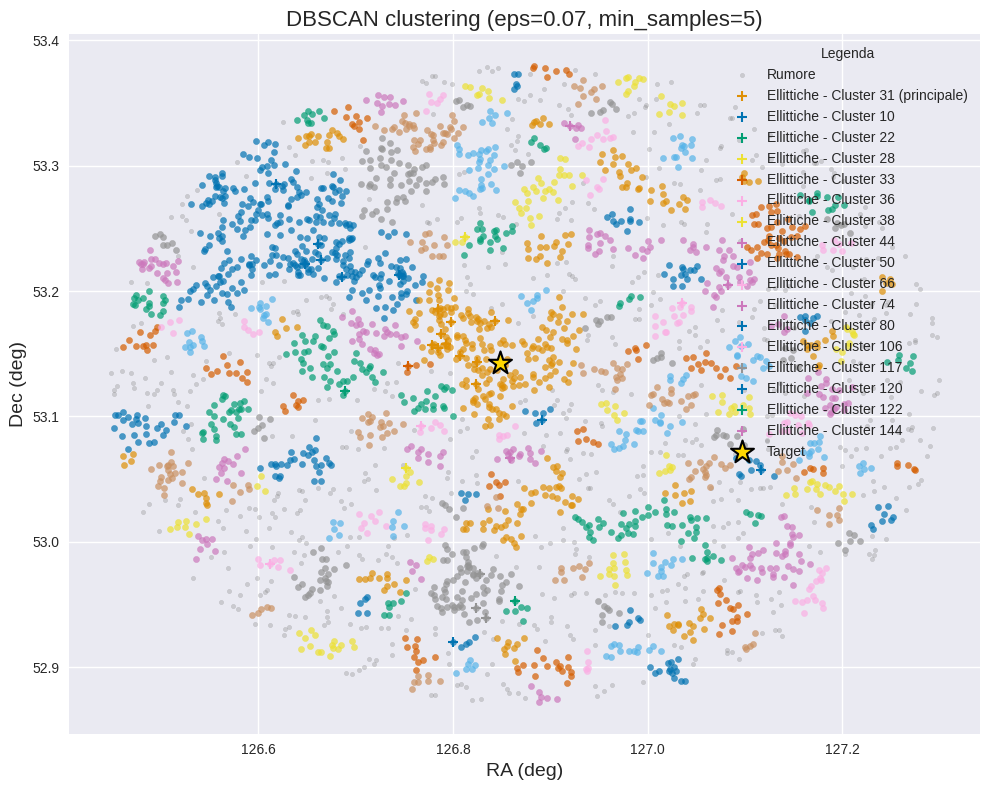

In [103]:
def apply_dbscan(data, eps=0.07, min_samples=5, ellipticals=None, target=None, show_redshifts=False):
    """Applica DBSCAN alle coordinate RA/Dec e mostra i cluster con ellittiche"""

    coords = data[['RAJ2000', 'DEJ2000']].values
    coords_scaled = StandardScaler().fit_transform(coords)

    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coords_scaled)
    labels = db.labels_

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    # Trova il cluster del target (se specificato)
    target_cluster_id = None
    if target is not None and 'SDSS9' in data.columns:
      match = data['SDSS9'] == target['SDSS9']
      if match.any():
        target_idx = match.idxmax()
        iloc_pos = data.index.get_loc(target_idx)
        target_cluster_id = labels[iloc_pos]

    # Inizializza conteggi
    ellipses_in_target_cluster = 0
    clusters_with_ellipticals = {}

    # Plot
    plt.figure(figsize=(10, 8))

    # Rumore
    noise_mask = labels == -1
    plt.scatter(data['RAJ2000'][noise_mask], data['DEJ2000'][noise_mask],
                c='gray', alpha=0.3, s=10, label='Rumore')
    # Etichette per i punti nel rumore
    if show_redshifts and 'zsp' in data.columns:
        texts_nois = []
        for i in data[noise_mask & data['zsp'].notna()].index:

            ra = data.at[i, 'RAJ2000']
            dec = data.at[i, 'DEJ2000']
            z_val = data.at[i, 'zsp']
            texts_nois.append(plt.text(ra, dec, f"{z_val:.3f}", fontsize=8, color='gray'))
        adjust_text(texts_nois, arrowprops=dict(arrowstyle='->', color='black'))

    # Ciclo sui cluster
    for cluster_id in sorted(set(labels)):
        if cluster_id == -1:
            continue

        cluster_mask = labels == cluster_id
        color = f'C{cluster_id % 10}'

        # Controlla ellittiche nel cluster
        ell_mask = cluster_mask & data['SDSS9'].isin(ellipticals['SDSS9']) if ellipticals is not None else np.zeros(len(data), dtype=bool)

        if ell_mask.any():
            # Salva info per legenda
            clusters_with_ellipticals[cluster_id] = {
                'color': color,
                'ra': data['RAJ2000'][ell_mask],
                'dec': data['DEJ2000'][ell_mask]
            }

            if cluster_id == target_cluster_id:
                ellipses_in_target_cluster = ell_mask.sum()

        # Disegna comunque tutti i punti (senza etichetta)
        plt.scatter(data['RAJ2000'][cluster_mask], data['DEJ2000'][cluster_mask],
                    s=20, alpha=0.7, color=color)

    # Disegna solo i cluster con ellittiche nella legenda
    for cluster_id in sorted(clusters_with_ellipticals, key=lambda x: x != target_cluster_id):
        info = clusters_with_ellipticals[cluster_id]
        label = f"Ellittiche - Cluster {cluster_id}"
        if cluster_id == target_cluster_id:
            label += " (principale)"
        plt.scatter(info['ra'], info['dec'], marker='+', s=60, linewidths=1.5,
                    color=info['color'], label=label)

    # Etichette dei redshift
        if show_redshifts and 'zsp' in data.columns:
            texts_clus=[]
            for i in data[cluster_mask & data['zsp'].notna()].index:
                ra = data.at[i, 'RAJ2000']
                dec = data.at[i, 'DEJ2000']
                z_val = data.at[i, 'zsp']
                texts_clus.append(plt.text(ra, dec, f"{z_val:.3f}", fontsize=8, color='darkgray'))
            adjust_text(texts_clus, arrowprops=dict(arrowstyle='->', color='black'))


    # Target
    if target is not None:
        plt.scatter(target['RAJ2000'], target['DEJ2000'],
                    marker='*', s=300, color='gold', edgecolor='black',
                    linewidth=1.5, label='Target')

    # Titolo e legenda compatta
    plt.xlabel('RA (deg)', fontsize=14)
    plt.ylabel('Dec (deg)', fontsize=14)
    plt.title(f'DBSCAN clustering (eps={eps}, min_samples={min_samples})', fontsize=16)
    plt.legend(loc='upper right', title='Legenda')
    plt.grid(True)
    plt.tight_layout()

    # Stampa riassuntiva
    print(f"\nCluster del target: {target_cluster_id}")
    if target_cluster_id != -1:
        print(f"→ Numero membri nel cluster del target: {(labels == target_cluster_id).sum()}")
        print(f"→ Ellittiche nel cluster del target: {ellipses_in_target_cluster}")
    else:
        print("Il target è etichettato come rumore (cluster -1)")

    other_clusters = [cid for cid in clusters_with_ellipticals if cid != target_cluster_id]
    if other_clusters:
        print(f"Cluster con almeno un'ellittica (escluso il target): {other_clusters}")
    else:
        print("Nessun altro cluster contiene galassie ellittiche")

    return labels


dbscan_labels = apply_dbscan(all_objects, eps=0.07, min_samples=5,
                             ellipticals=ellipticals, target=target)


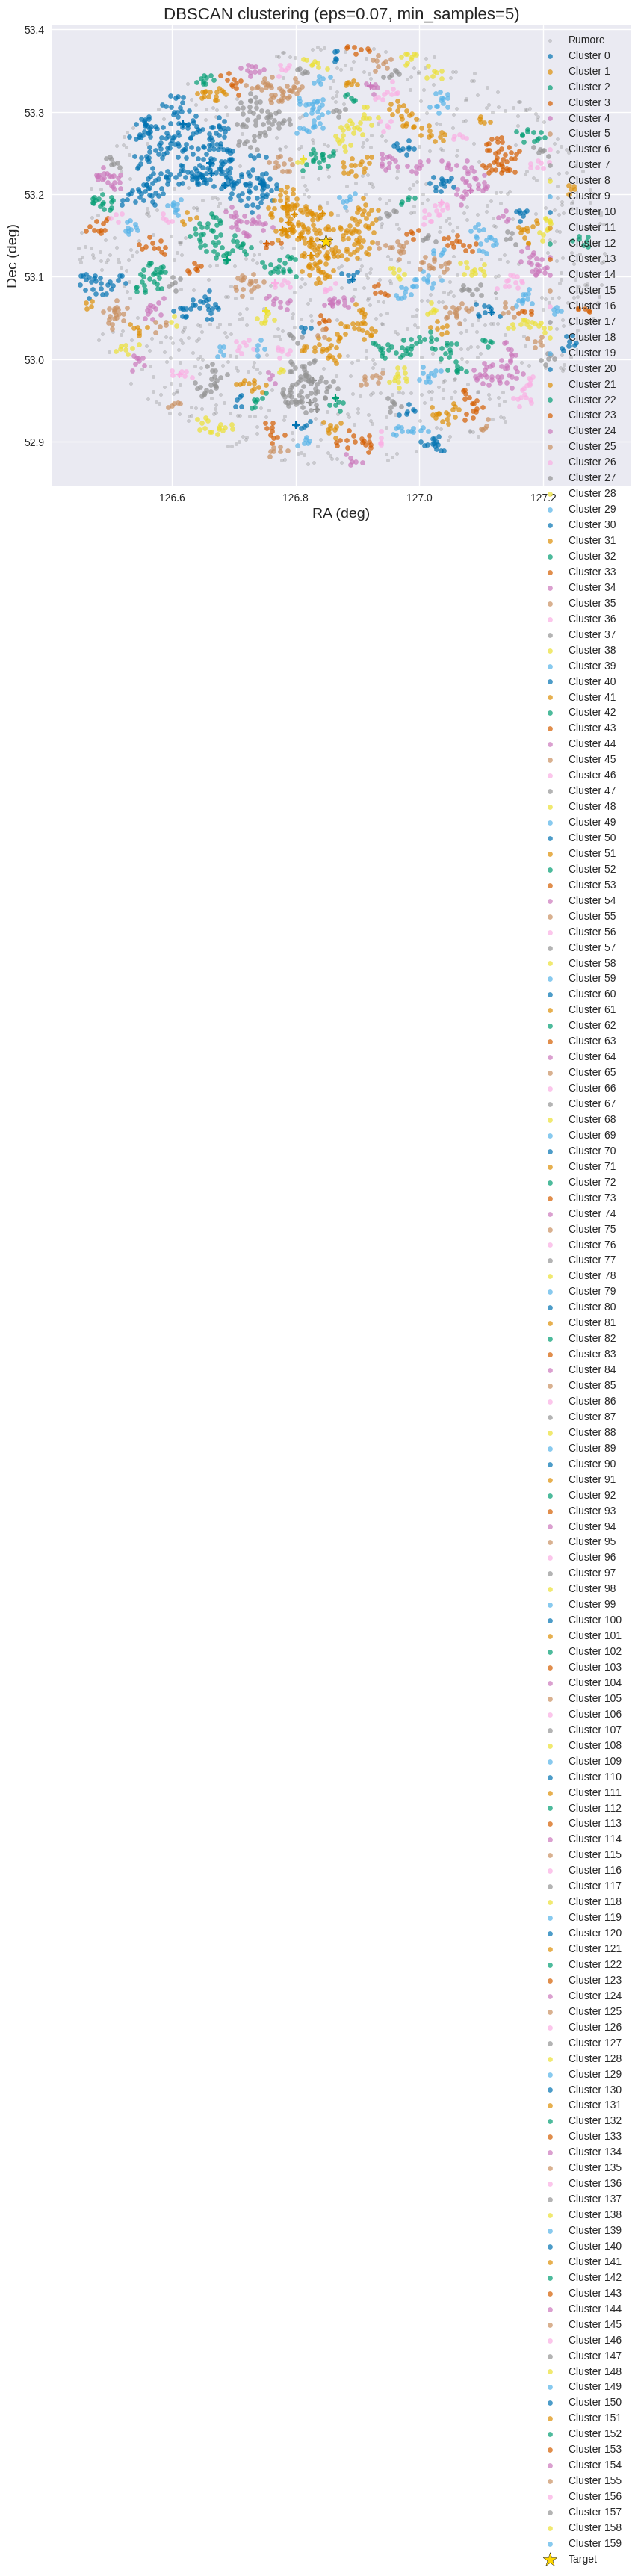

In [90]:
def apply_dbscan(data, eps=0.07, min_samples=5, ellipticals=None, target=None, show_redshifts=False):
    """Applica DBSCAN alle coordinate RA/Dec e mostra redshift se richiesto"""

    coords = data[['RAJ2000', 'DEJ2000']].values
    coords_scaled = StandardScaler().fit_transform(coords)

    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coords_scaled)
    labels = db.labels_

    plt.figure(figsize=(10, 8))

    # Rumore
    noise_mask = labels == -1
    plt.scatter(data['RAJ2000'][noise_mask], data['DEJ2000'][noise_mask],
                c='gray', alpha=0.3, s=10, label='Rumore')

    # Cluster
    for cluster_id in set(labels):
        if cluster_id == -1:
            continue

        cluster_mask = labels == cluster_id
        color = f'C{cluster_id % 10}'

        plt.scatter(data['RAJ2000'][cluster_mask], data['DEJ2000'][cluster_mask],
                    s=20, label=f'Cluster {cluster_id}', alpha=0.7, color=color)

        # Ellittiche
        if ellipticals is not None and 'SDSS9' in data.columns:
            ell_mask = cluster_mask & data['SDSS9'].isin(ellipticals['SDSS9'])
            plt.scatter(data['RAJ2000'][ell_mask], data['DEJ2000'][ell_mask],
                        marker='+', s=60, linewidths=1.5, color=color)

        # Etichette dei redshift
        if show_redshifts and 'zsp' in data.columns:
            for i in data[cluster_mask & data['zsp'].notna()].index:
                ra = data.at[i, 'RAJ2000']
                dec = data.at[i, 'DEJ2000']
                z_val = data.at[i, 'zsp']
                plt.text(ra, dec + 0.002, f"{z_val:.3f}", fontsize=8, color=color)

    # Target
    if target is not None:
        plt.scatter(target['RAJ2000'], target['DEJ2000'],
                    s=200, marker='*', color='gold', edgecolor='black', label='Target', zorder=10)

    plt.xlabel('RA (deg)', fontsize=14)
    plt.ylabel('Dec (deg)', fontsize=14)
    plt.title(f'DBSCAN clustering (eps={eps}, min_samples={min_samples})', fontsize=16)
    plt.legend()
    plt.grid(True)

    return labels


dbscan_labels = apply_dbscan(all_objects, eps=0.07, min_samples=5,
                             ellipticals=ellipticals, target=target)




Metriche per GMM:
Matrice di confusione:
[[2703  334]
 [   2   16]]
Precision: 0.046
Recall: 0.889
Purezza: 0.046
Completezza: 0.889

Metriche per DBSCAN:
Matrice di confusione:
[[2844  193]
 [  12    6]]
Precision: 0.030
Recall: 0.333
Purezza: 0.030
Completezza: 0.333


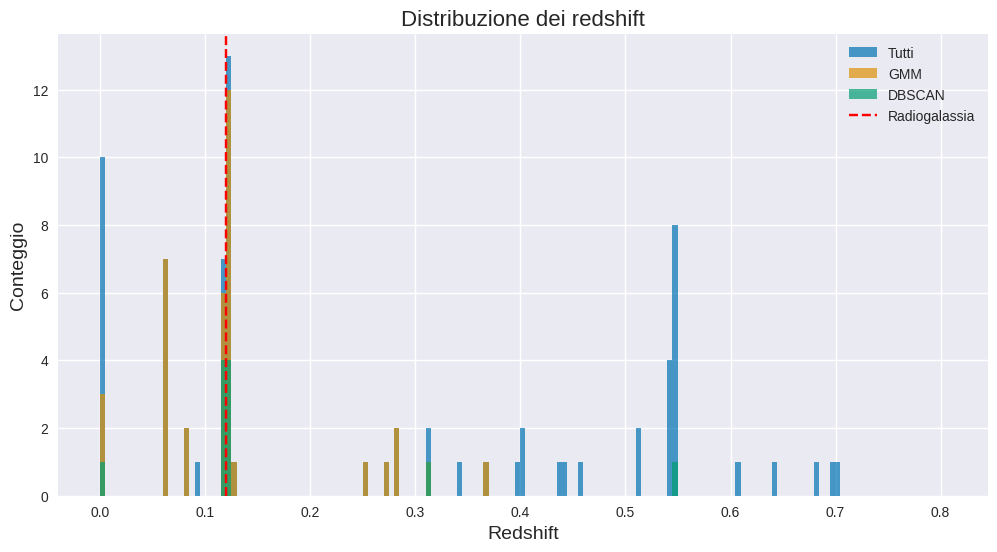

In [46]:
"""
## 6. Validazione con Redshift Spettroscopici

Utilizziamo i redshift spettroscopici disponibili per validare i risultati.
"""

# Assumiamo che la radiogalassia centrale abbia redshift z_RG
z_RG = 0.11922  # Sostituire con il valore reale

# Carica i redshift spettroscopici (se disponibili)
try:
    z_spec = all_objects['zsp'].values
    has_z_spec = ~np.isnan(z_spec)

    # Definisci i veri membri (entro delta_z < 0.005 dalla RG)
    true_members = np.abs(z_spec - z_RG) < 0.005

    # Confronta con i risultati del clustering
    gmm_predicted = np.zeros_like(true_members, dtype=bool)
    gmm_predicted[cluster_mask] = True

    dbscan_predicted = np.zeros_like(true_members, dtype=bool)
    dbscan_predicted[main_cluster_mask] = True

    # Metriche di performance
    def print_metrics(true, pred, method):
        cm = confusion_matrix(true, pred)
        precision = precision_score(true, pred)
        recall = recall_score(true, pred)

        print(f"\nMetriche per {method}:")
        print(f"Matrice di confusione:\n{cm}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall: {recall:.3f}")
        print(f"Purezza: {cm[1,1]/(cm[0,1]+cm[1,1]):.3f}")
        print(f"Completezza: {cm[1,1]/(cm[1,0]+cm[1,1]):.3f}")

    print_metrics(true_members, gmm_predicted, "GMM")
    print_metrics(true_members, dbscan_predicted, "DBSCAN")




    # Plot dei redshift
    plt.figure(figsize=(12, 6))
    z_min, z_max = np.nanmin(z_spec), 0.8
    bin_width = 0.005
    bins = np.arange(z_min, z_max + bin_width, bin_width)

    plt.hist(z_spec[has_z_spec], bins=bins, alpha=0.7, label='Tutti')
    plt.hist(z_spec[gmm_predicted & has_z_spec], bins=bins, alpha=0.7, label='GMM')
    plt.hist(z_spec[dbscan_predicted & has_z_spec], bins=bins, alpha=0.7, label='DBSCAN')


    plt.axvline(x=z_RG, color='r', linestyle='--', label='Radiogalassia')
    plt.xlabel('Redshift', fontsize=14)
    plt.ylabel('Conteggio', fontsize=14)
    plt.title('Distribuzione dei redshift', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

except KeyError:
    print("Nessun dato di redshift spettroscopico disponibile per la validazione.")


Approccio ibrido 1: GMM + DBSCAN

Cluster del target: 8
→ Numero membri nel cluster del target: 42
→ Ellittiche nel cluster del target: 11
Cluster con almeno un'ellittica (escluso il target): [np.int64(5), np.int64(7), np.int64(20), np.int64(22), np.int64(32)]
Numero di membri con approccio ibrido: 42


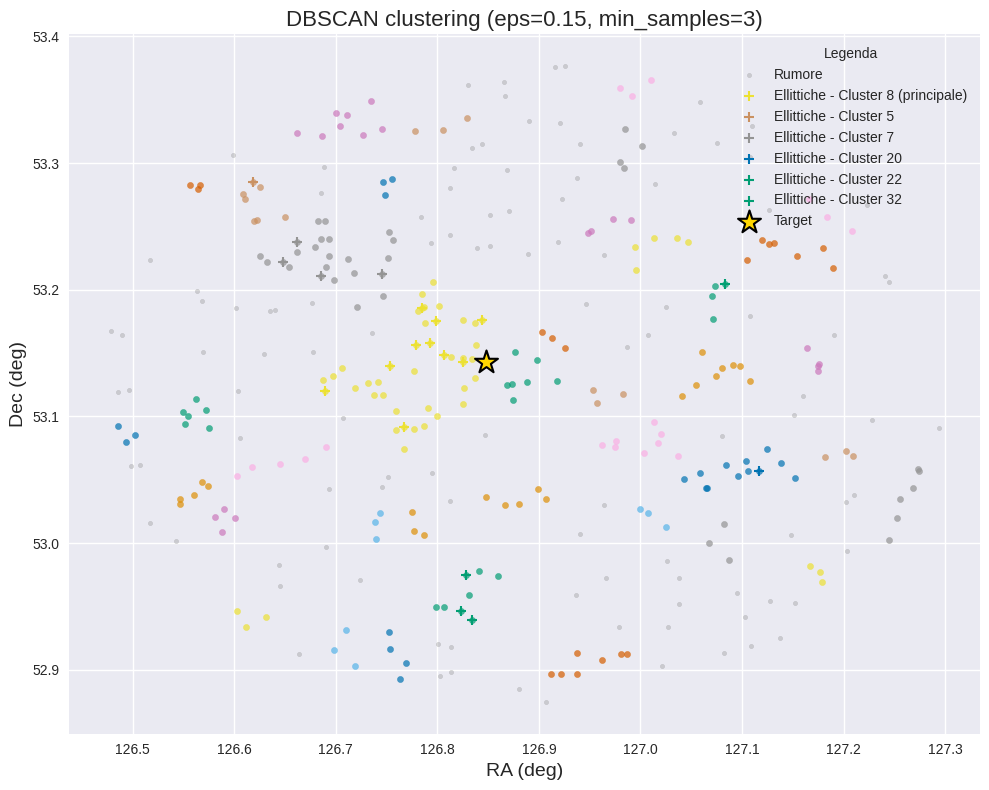

In [51]:
"""
## 7. Approccio Ibrido

Combiniamo GMM nel CMD e DBSCAN in RA/Dec per una selezione più robusta.
"""
# Modello 1: GMM in CMD seguito da DBSCAN in RA/Dec
print("\nApproccio ibrido 1: GMM + DBSCAN")

# Prendiamo i candidati dal GMM
gmm_candidates = all_objects[cluster_mask]

# Applica DBSCAN a questi candidati
hybrid_labels = apply_dbscan(gmm_candidates, eps=0.15, min_samples=3, ellipticals=ellipticals, target=target)

# Gestione del caso in cui DBSCAN non trova cluster
if len(np.unique(hybrid_labels[hybrid_labels != -1])) == 0:
    print("DBSCAN non ha trovato cluster - usando tutti i candidati GMM")
    hybrid_members = gmm_candidates
else:
    # Trova l’indice del target nel DataFrame gmm_candidates
    try:
      target_idx_hybrid = gmm_candidates[gmm_candidates['SDSS9'] == target['SDSS9']].index[0]
      target_cluster_id = hybrid_labels[gmm_candidates.index.get_loc(target_idx_hybrid)]

      if target_cluster_id == -1:
          print("Il target è considerato rumore da DBSCAN nell'approccio ibrido.")
          hybrid_members = gmm_candidates.iloc[[]]  # Vuoto
      else:
          # Seleziona solo il cluster che contiene il target
          hybrid_cluster_mask = hybrid_labels == target_cluster_id
          hybrid_members = gmm_candidates[hybrid_cluster_mask]

    except IndexError:
      print("Il target non è stato trovato tra i candidati GMM.")
      hybrid_members = gmm_candidates.iloc[[]]  # Vuoto

print(f"Numero di membri con approccio ibrido: {len(hybrid_members)}")




Metriche per Approccio Ibrido:
Matrice di confusione:
[[2995   42]
 [  18    0]]
Precision: 0.000
Recall: 0.000
Purezza: 0.000
Completezza: 0.000


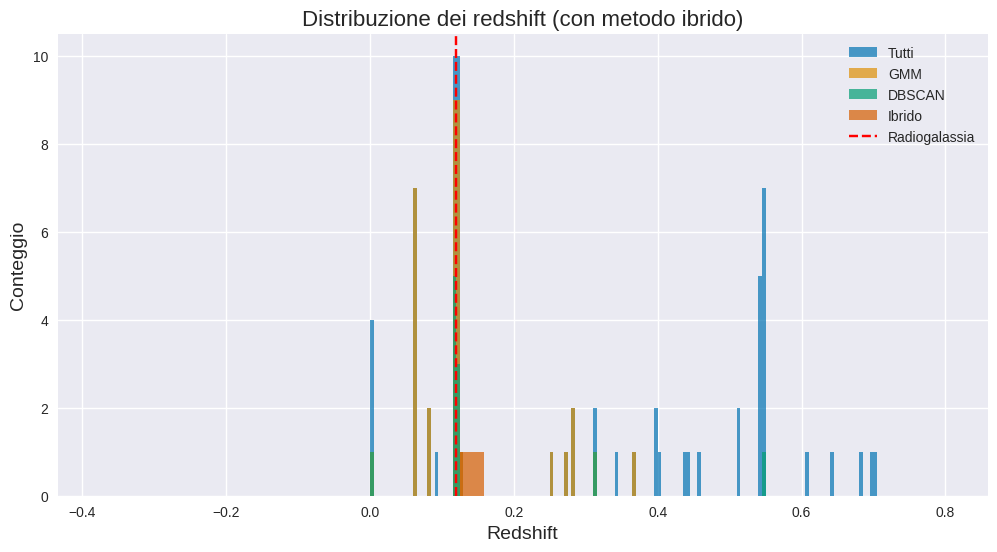

In [54]:
# Validazione con redshift spettroscopici per l'approccio ibrido
try:
    hybrid_predicted = np.zeros_like(true_members, dtype=bool)
    hybrid_predicted[hybrid_members.index] = True

    print_metrics(true_members, hybrid_predicted, "Approccio Ibrido")

    # Aggiungi l'istogramma anche per l'approccio ibrido
    plt.figure(figsize=(12, 6))
    z_min, z_max = 0., 0.8
    bin_width = 0.005
    bins = np.arange(z_min, z_max + bin_width, bin_width)

    plt.hist(z_spec[has_z_spec], bins=bins, alpha=0.7, label='Tutti')
    plt.hist(z_spec[gmm_predicted & has_z_spec], bins=bins, alpha=0.7, label='GMM')
    plt.hist(z_spec[dbscan_predicted & has_z_spec], bins=bins, alpha=0.7, label='DBSCAN')
    plt.hist(z_spec[hybrid_predicted & has_z_spec], bins=30, alpha=0.7, label='Ibrido')

    plt.axvline(x=z_RG, color='r', linestyle='--', label='Radiogalassia')
    plt.xlabel('Redshift', fontsize=14)
    plt.ylabel('Conteggio', fontsize=14)
    plt.title('Distribuzione dei redshift (con metodo ibrido)', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"\nErrore durante la validazione dell’approccio ibrido: {e}")


Usiamo il file con solo le galassie


GMM con 2 componenti:


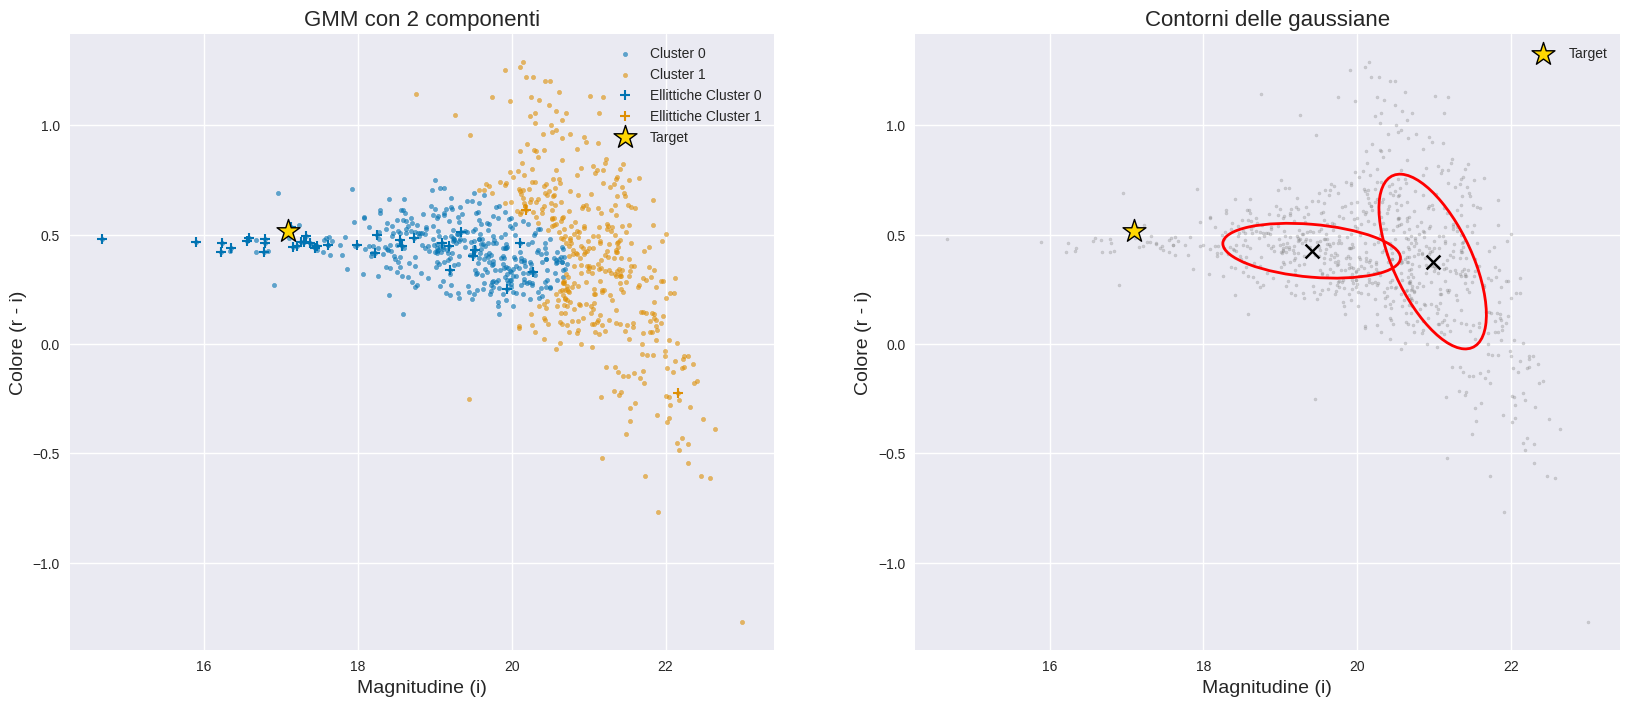


GMM con 3 componenti:


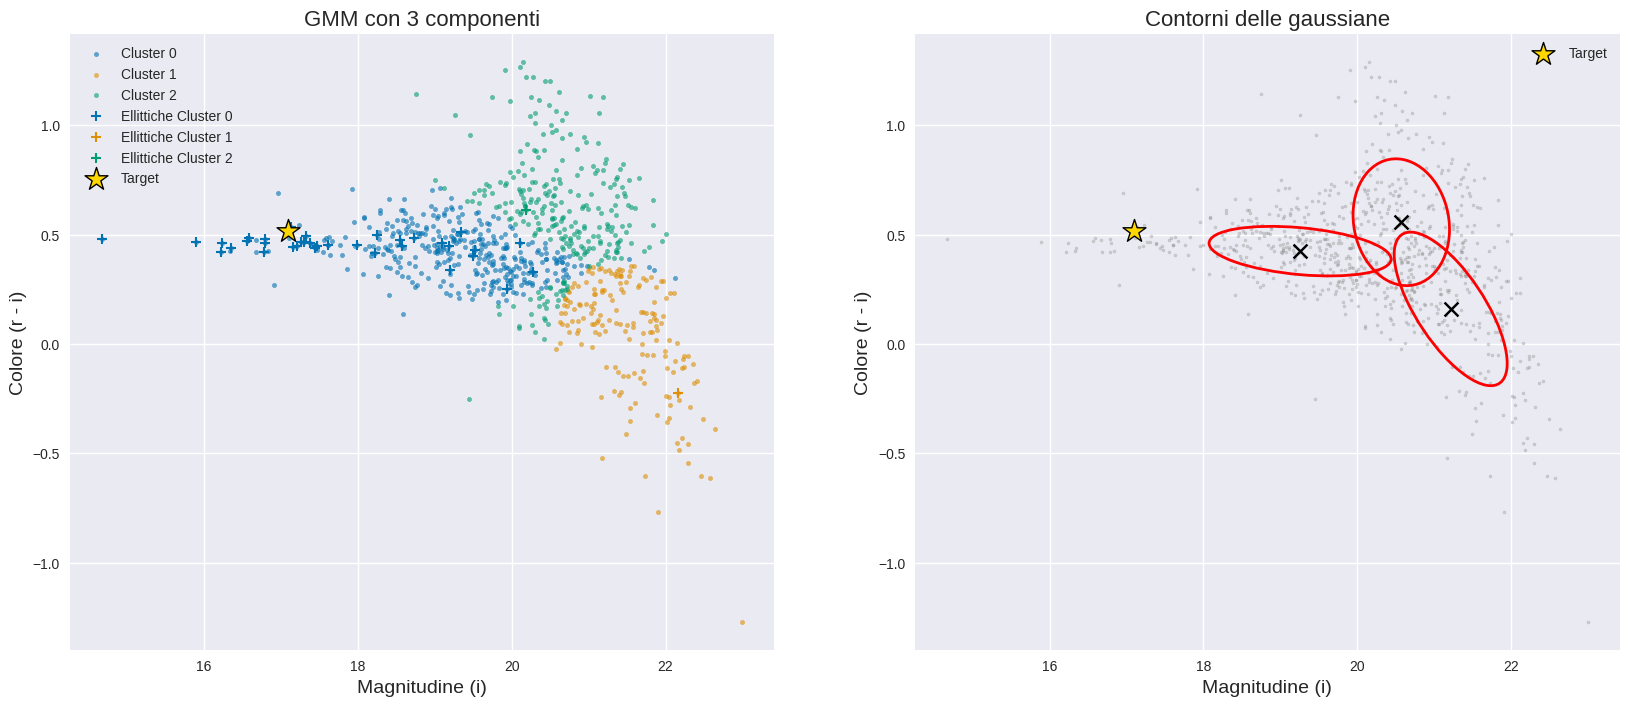


GMM con 4 componenti:


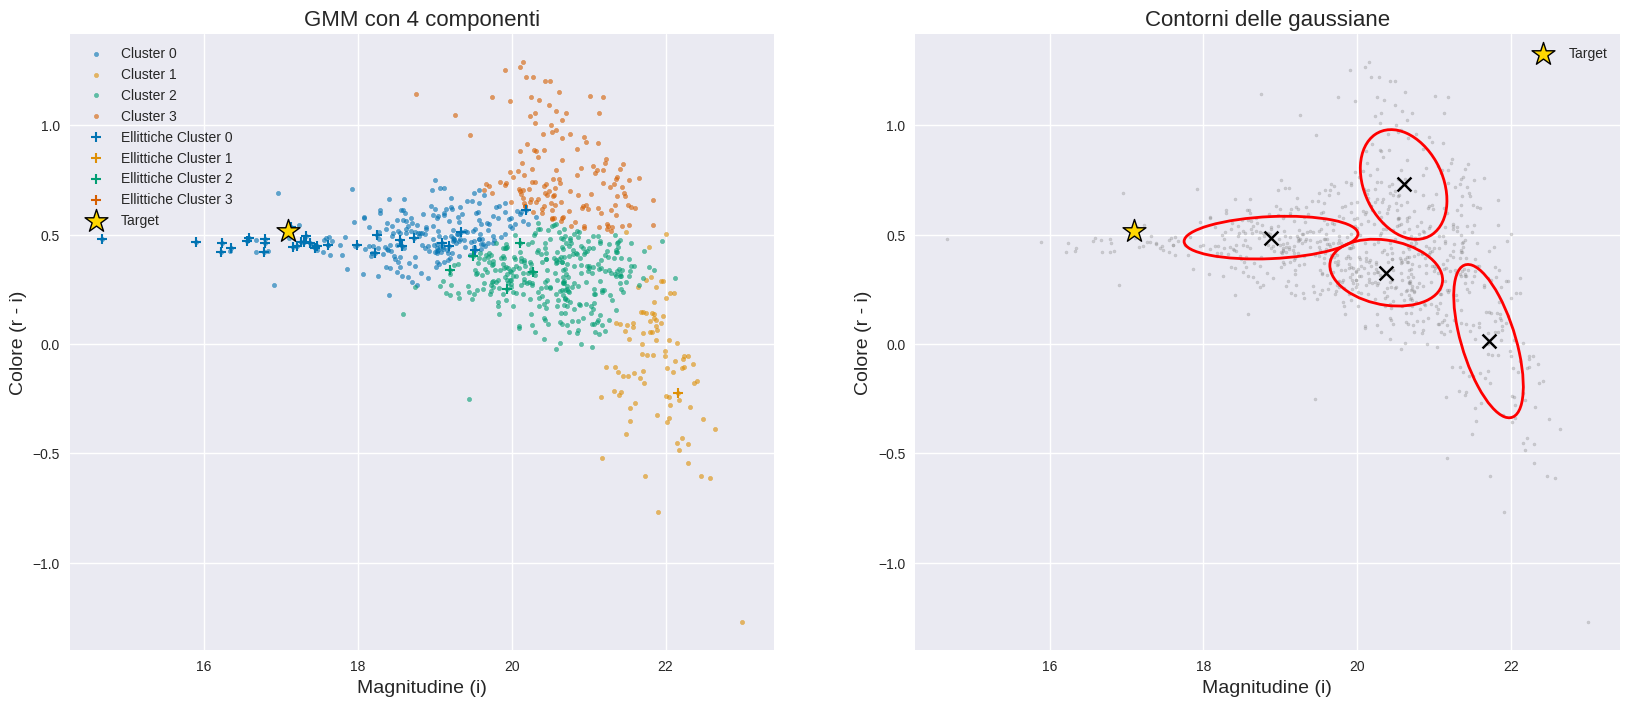


GMM con 5 componenti:


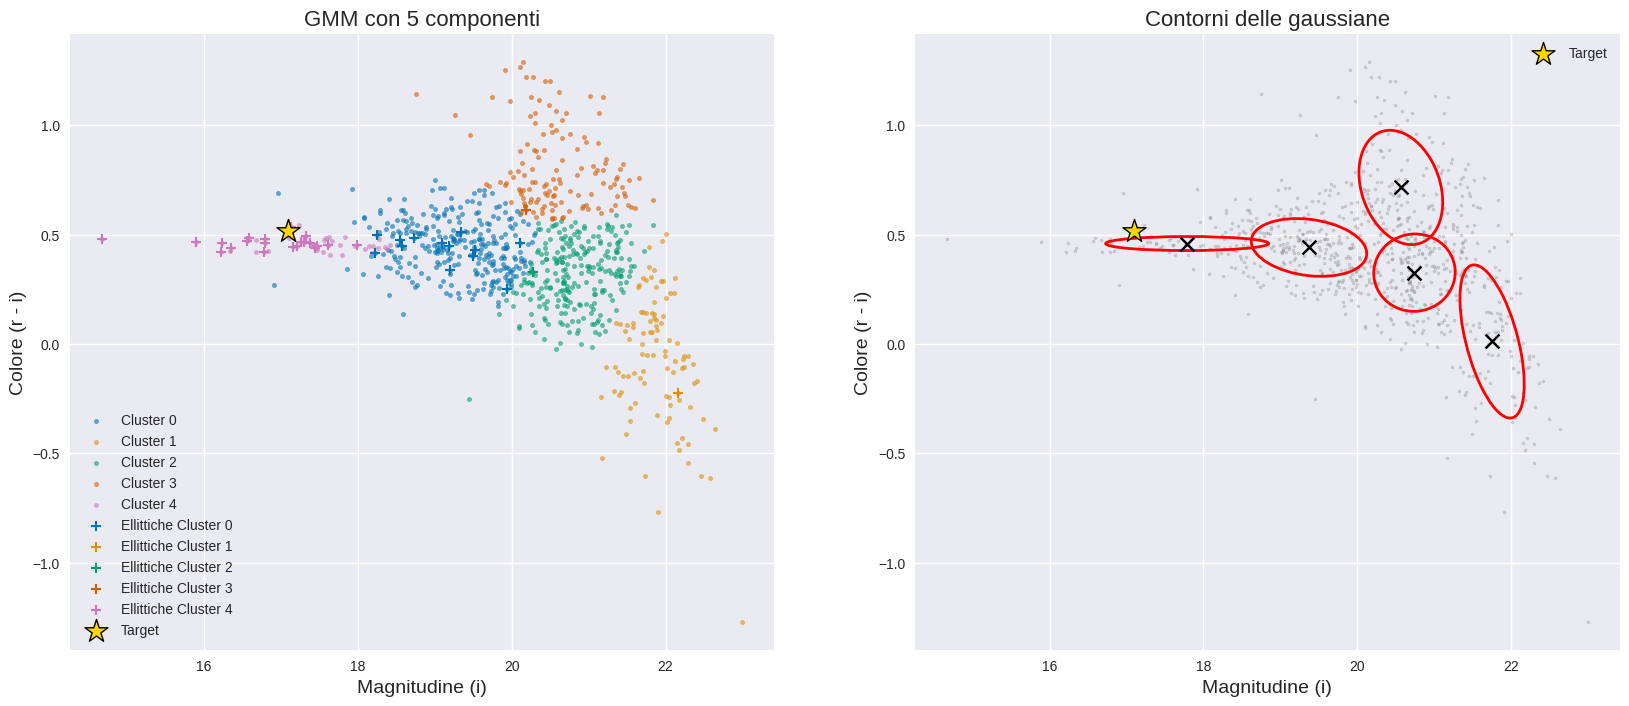


GMM con 6 componenti:


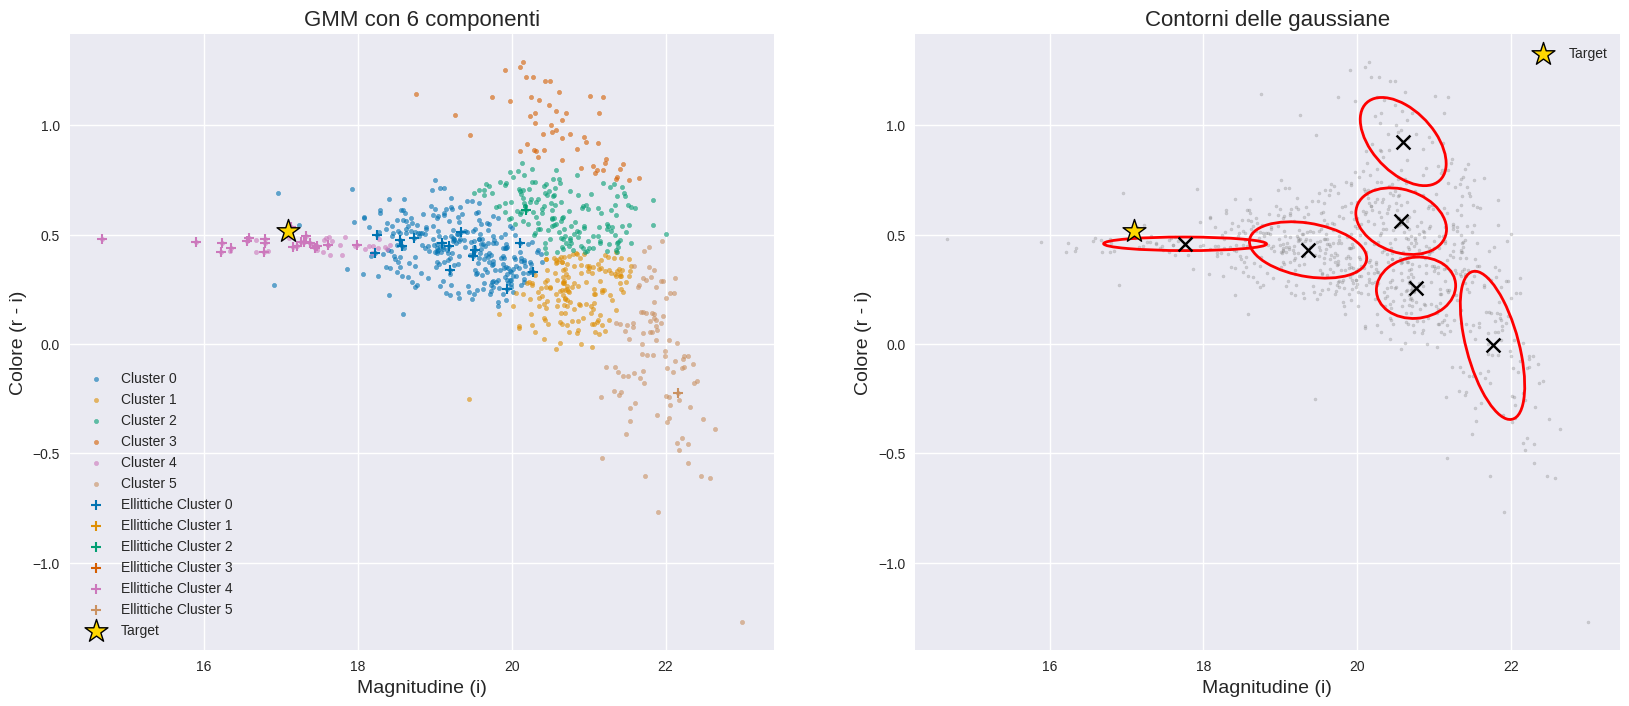


GMM con 7 componenti:


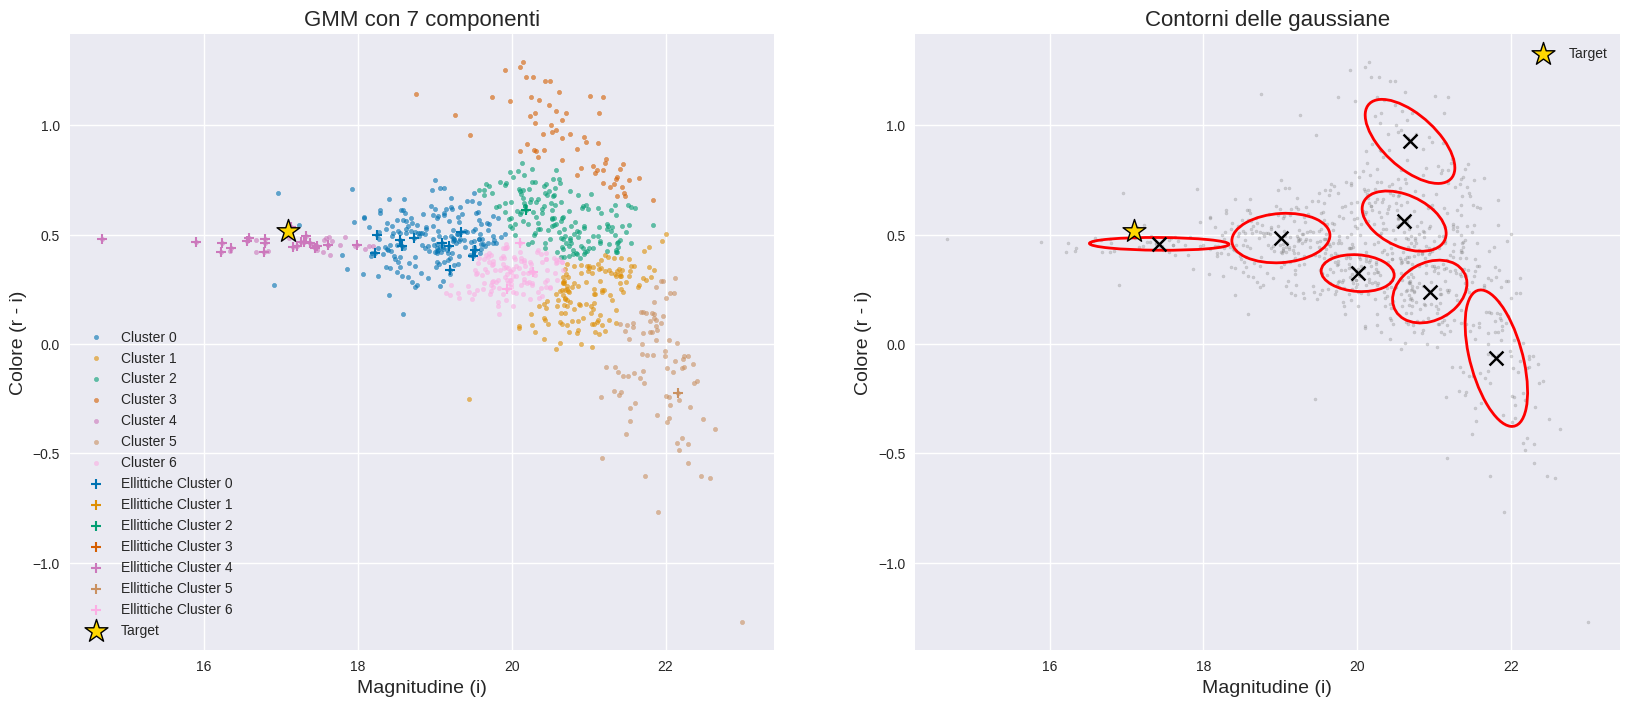


GMM con 8 componenti:


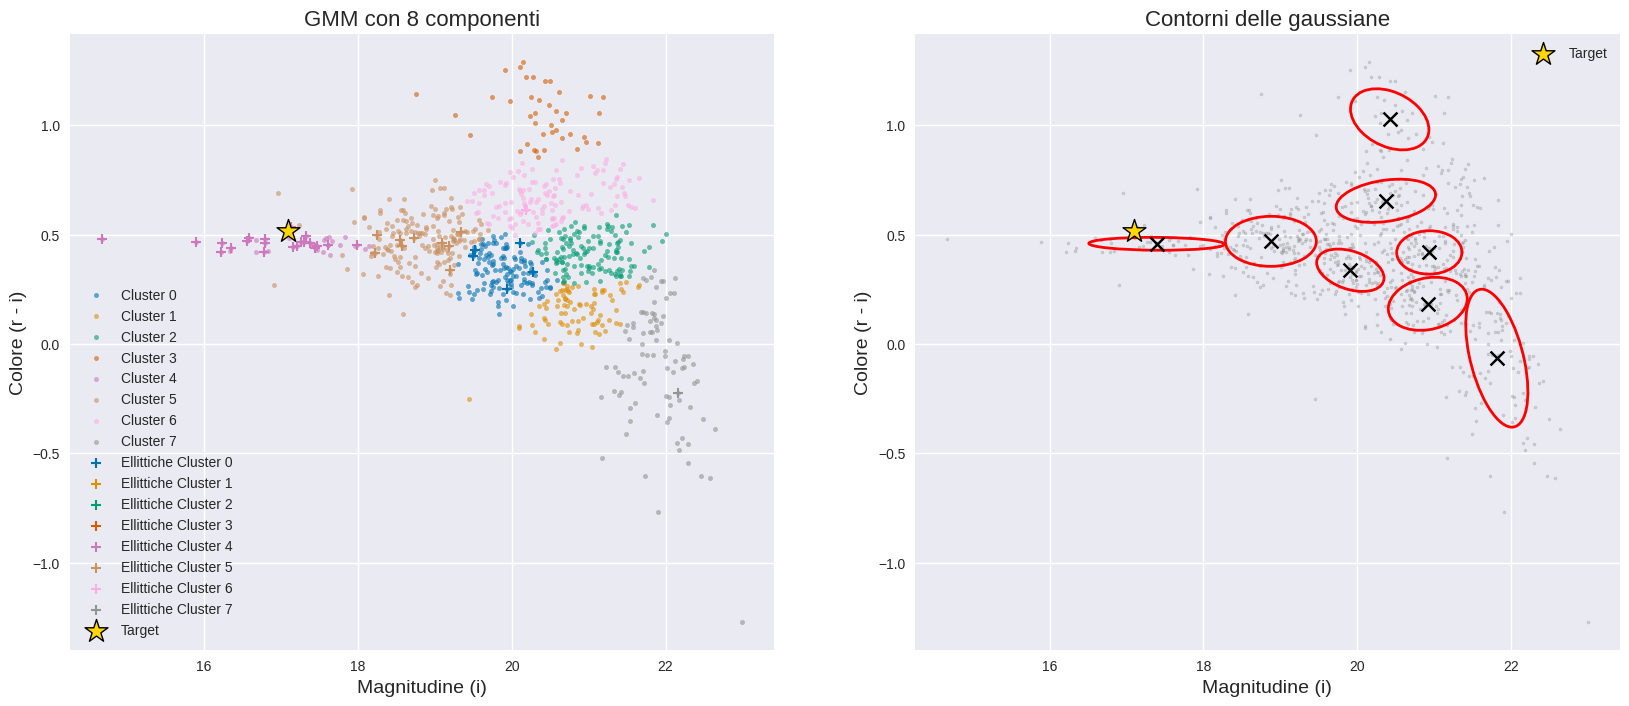


GMM con 9 componenti:


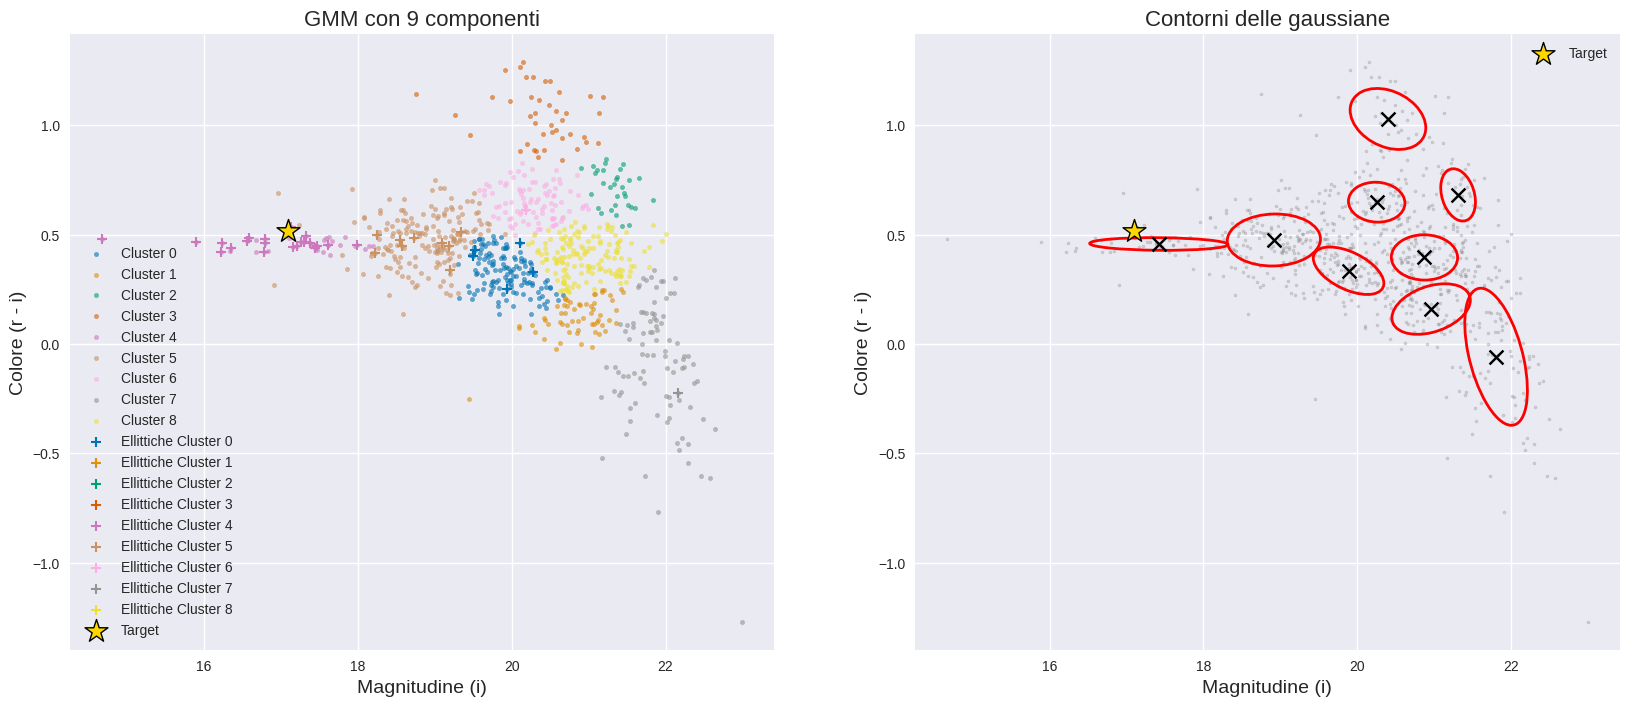

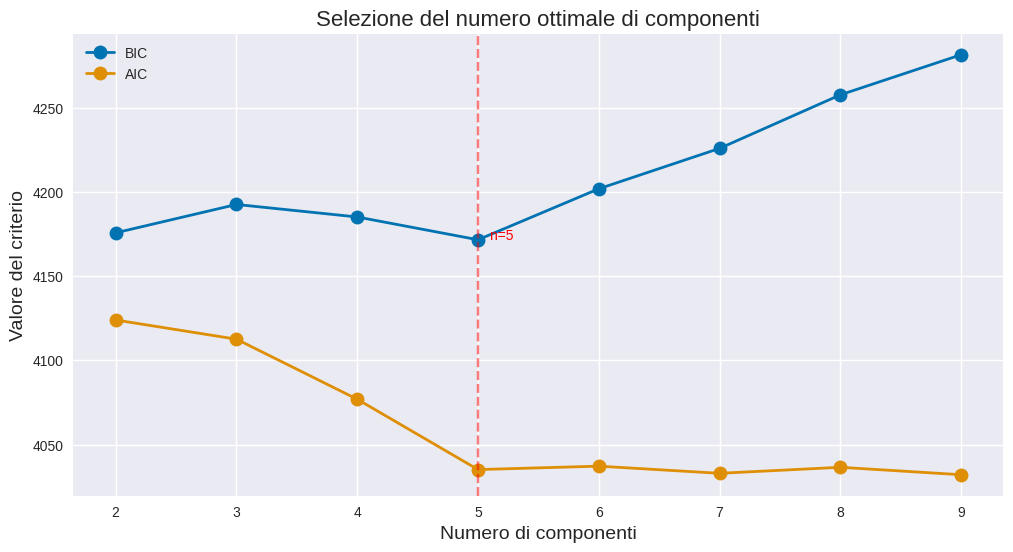


Numero ottimale di componenti (basato su BIC): 5


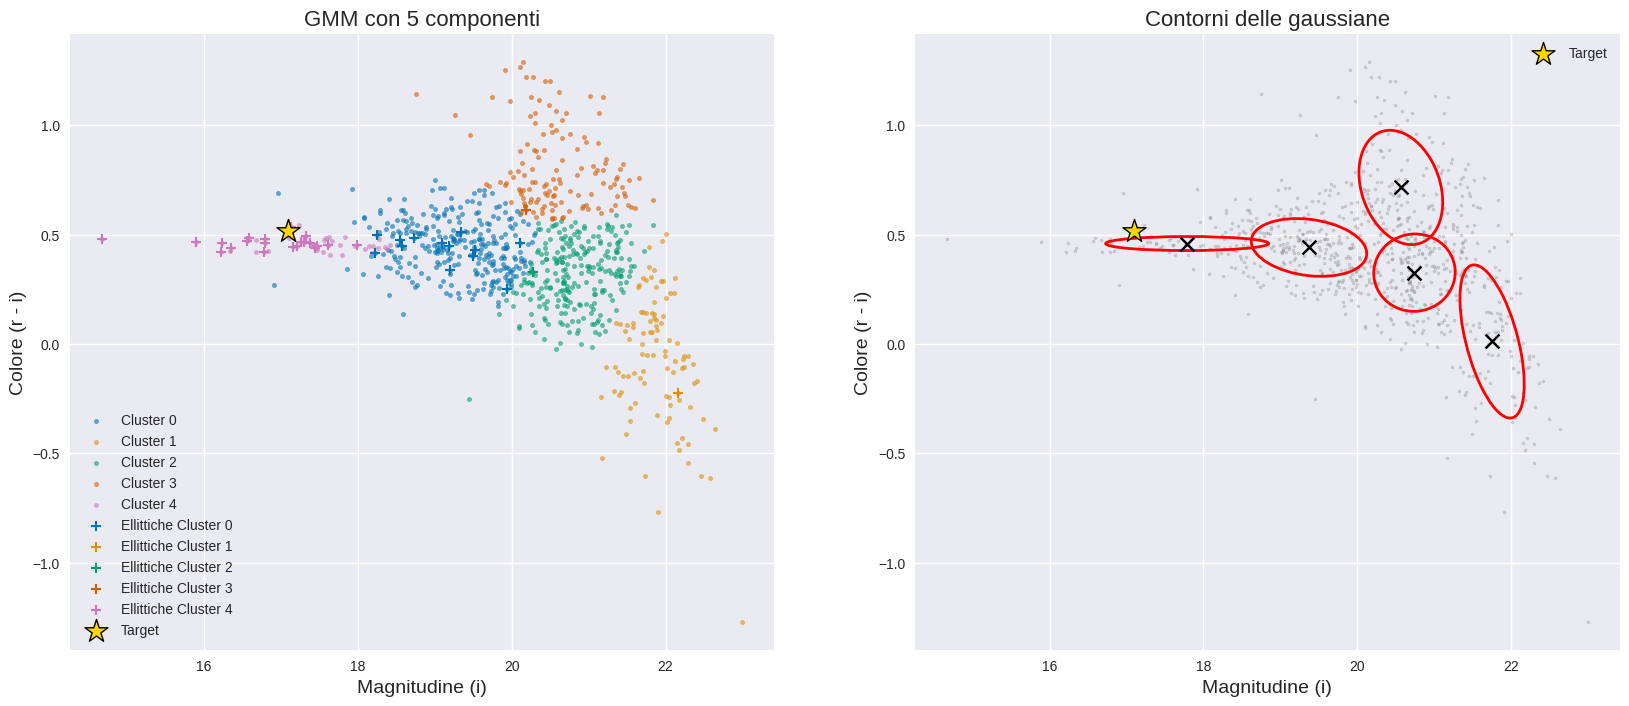


Statistiche del cluster:
- Numero membri: 40/819
- Frazione: 4.88%
- Colore medio (r-i): 0.46
- Magnitudine media (i): 17.12

Componente selezionata (contiene il target):
- Indice componente: 4
- Media colore (r-i): -1.90
- Media magnitudine (i): 0.19


In [55]:
# Applica GMM con diversi numeri di componenti
n_components_range = range(2, 10)
bics, aics = [], []

# Prima filtraggio dei dati per evitare warning
clean_galaxies = galaxies[
    (galaxies['imag'].notna()) &
    (galaxies['rmag'].notna()) &
    (galaxies['imag'] > 0) &
    (galaxies['rmag'] > 0)
].copy()

# Ricrea X usato nel fit
X = np.column_stack([
    clean_galaxies['imag'],
    clean_galaxies['rmag'] - clean_galaxies['imag']
])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Trasforma anche il target nello stesso spazio
target_X = np.array([[target['imag'], target['rmag'] - target['imag']]])
target_X_scaled = scaler.transform(target_X)


for n in n_components_range:
    print(f"\nGMM con {n} componenti:")
    try:
        gmm, labels, probs, bic, aic = fit_gmm(clean_galaxies, n_components=n, target=target, ellipticals=ellipticals)
        bics.append(bic)
        aics.append(aic)
    except Exception as e:
        print(f"Errore con {n} componenti: {str(e)}")
        bics.append(np.inf)
        aics.append(np.inf)

# Plot migliorato di BIC e AIC
plt.figure(figsize=(12, 6))
plt.plot(n_components_range, bics, 'o-', label='BIC', linewidth=2, markersize=10)
plt.plot(n_components_range, aics, 'o-', label='AIC', linewidth=2, markersize=10)

# Evidenzia il minimo per BIC
best_n_bic = n_components_range[np.argmin(bics)]
plt.axvline(x=best_n_bic, color='r', linestyle='--', alpha=0.5)
plt.text(best_n_bic+0.1, np.min(bics), f'n={best_n_bic}', color='r')

plt.xlabel('Numero di componenti', fontsize=14)
plt.ylabel('Valore del criterio', fontsize=14)
plt.title('Selezione del numero ottimale di componenti', fontsize=16)
plt.xticks(n_components_range)
plt.legend()
plt.grid(True)
plt.show()

# Selezione del modello migliore (BIC più basso)
best_n = best_n_bic
print(f"\nNumero ottimale di componenti (basato su BIC): {best_n}")

# Fit del modello finale con controllo robusto
try:
    final_gmm, final_labels, final_probs, _, _ = fit_gmm(
        clean_galaxies,
        n_components=best_n,
        target=target,
        ellipticals=ellipticals
    )

    # Identifica la componente che contiene l'oggetto target
    # Prima troviamo l'indice del target nel dataframe clean_galaxies
    target_idx = clean_galaxies[clean_galaxies['SDSS9'] == target['SDSS9']].index[0]
    # Poi troviamo la componente a cui appartiene (quella con probabilità massima)
    # Calcola le probabilità del target usando il GMM
    target_probs = final_gmm.predict_proba(target_X_scaled)
    red_sequence_idx = np.argmax(target_probs[0])


    # Seleziona membri con probabilità > 0.7 e statistiche
    cluster_mask = final_probs[:, red_sequence_idx] > 0.7
    cluster_members = clean_galaxies[cluster_mask]

    print("\nStatistiche del cluster:")
    print(f"- Numero membri: {len(cluster_members)}/{len(clean_galaxies)}")
    print(f"- Frazione: {len(cluster_members)/len(clean_galaxies):.2%}")
    print(f"- Colore medio (r-i): {np.mean(cluster_members['rmag'] - cluster_members['imag']):.2f}")
    print(f"- Magnitudine media (i): {np.mean(cluster_members['imag']):.2f}")

    # Aggiungi informazioni sulla componente selezionata
    print(f"\nComponente selezionata (contiene il target):")
    print(f"- Indice componente: {red_sequence_idx}")
    print(f"- Media colore (r-i): {final_gmm.means_[red_sequence_idx, 0]:.2f}")
    print(f"- Media magnitudine (i): {final_gmm.means_[red_sequence_idx, 1]:.2f}")

except Exception as e:
    print(f"\nErrore nel fitting finale: {str(e)}")
    print("Consigli:")
    print("- Verifica la distribuzione dei dati")
    print("- Prova a standardizzare manualmente le features")
    print("- Considera meno componenti se il modello è troppo complesso")



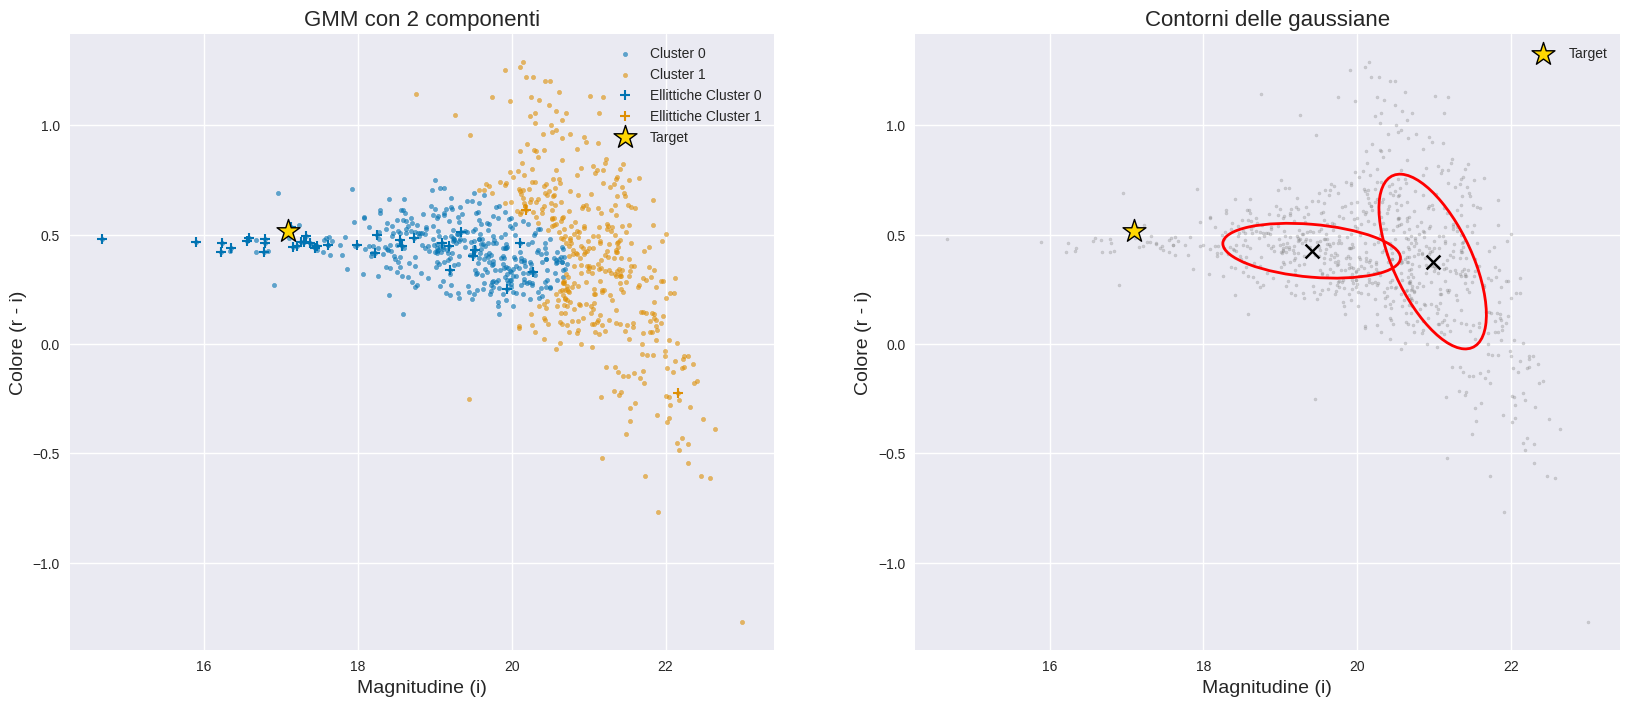


Numero di membri del cluster con GMM a 2 componenti: 341


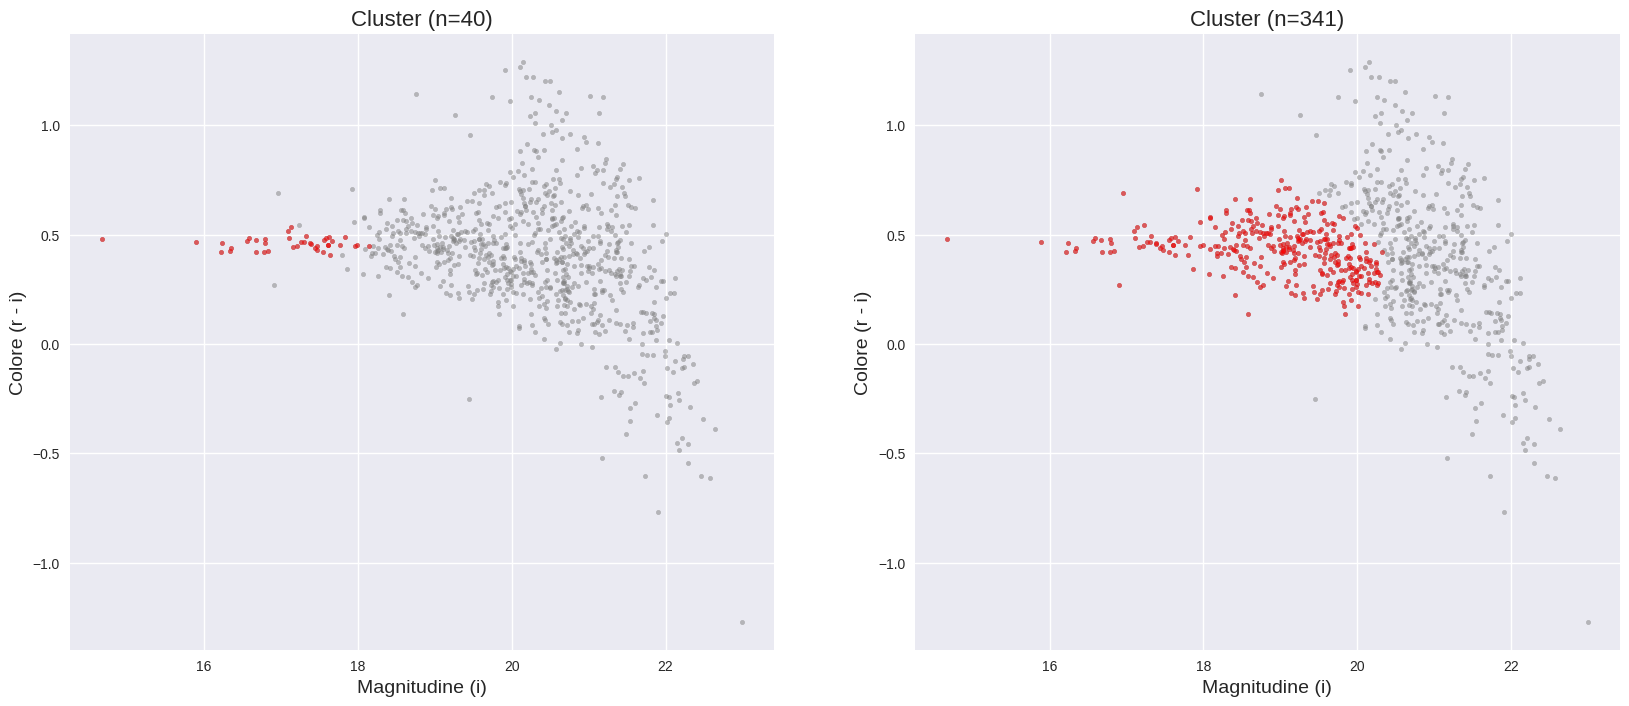

In [56]:
"""
## 4. Confronto: GMM a 2 componenti

Testiamo anche un modello più semplice con solo 2 componenti per confronto.
"""

# Fit del modello a 2 componenti
gmm_2, labels_2, probs_2, _, _ = fit_gmm(galaxies, n_components=2, target=target,  ellipticals=ellipticals)

# Ricrea le feature usate nel GMM
X = np.column_stack([
    galaxies['imag'],
    galaxies['rmag'] - galaxies['imag']
])

# Standardizza come nel fit_gmm
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Prepara e standardizza anche il target
target_X = np.array([[target['imag'], target['rmag'] - target['imag']]])
target_X_scaled = scaler.transform(target_X)

# Calcola le probabilità del target
target_probs_2 = gmm_2.predict_proba(target_X_scaled)
red_sequence_idx_2 = np.argmax(target_probs_2[0])


# Seleziona membri del cluster
cluster_mask_2 = probs_2[:, red_sequence_idx_2] > 0.7
cluster_members_2 = galaxies[cluster_mask_2]

print(f"\nNumero di membri del cluster con GMM a 2 componenti: {len(cluster_members_2)}")

# Confronto visivo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot del modello ottimale
plot_cmd(galaxies, "GMM ottimale", ax1, color='gray')
plot_cmd(cluster_members, f"Cluster (n={len(cluster_members)})", ax1, color='red')

# Plot del modello a 2 componenti
plot_cmd(galaxies, "GMM a 2 componenti", ax2, color='gray')
plot_cmd(cluster_members_2, f"Cluster (n={len(cluster_members_2)})", ax2, color='red')

plt.show()


Cluster del target: 14
→ Numero membri nel cluster del target: 13
→ Ellittiche nel cluster del target: 3
Cluster con almeno un'ellittica (escluso il target): [np.int64(7), np.int64(10), np.int64(11), np.int64(18), np.int64(21), np.int64(24), np.int64(25), np.int64(29)]


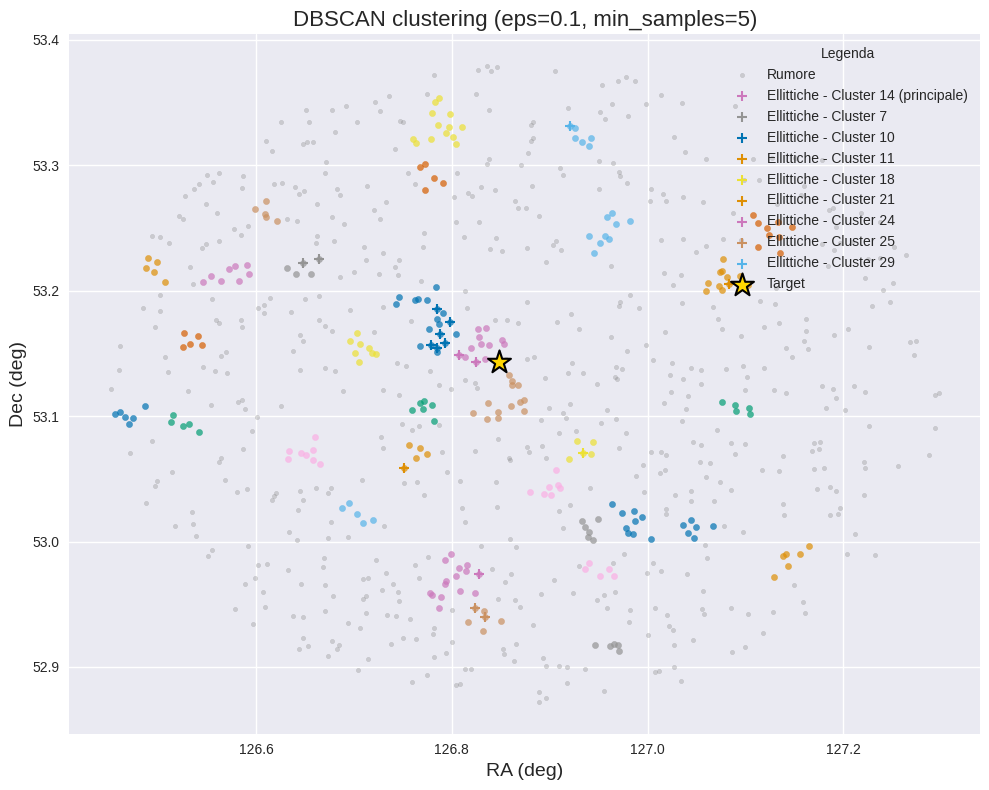

In [111]:
"""
## 5. Confronto con DBSCAN in RA/Dec

Applichiamo DBSCAN alle coordinate celesti per identificare overdensità spaziali.
"""

dbscan_labels = apply_dbscan(galaxies, eps=0.1, min_samples=5,
                             ellipticals=ellipticals, target=target)



Metriche per GMM:
Matrice di confusione:
[[778  25]
 [  1  15]]
Precision: 0.375
Recall: 0.938
Purezza: 0.375
Completezza: 0.938

Metriche per DBSCAN:
Matrice di confusione:
[[620 183]
 [  8   8]]
Precision: 0.042
Recall: 0.500
Purezza: 0.042
Completezza: 0.500


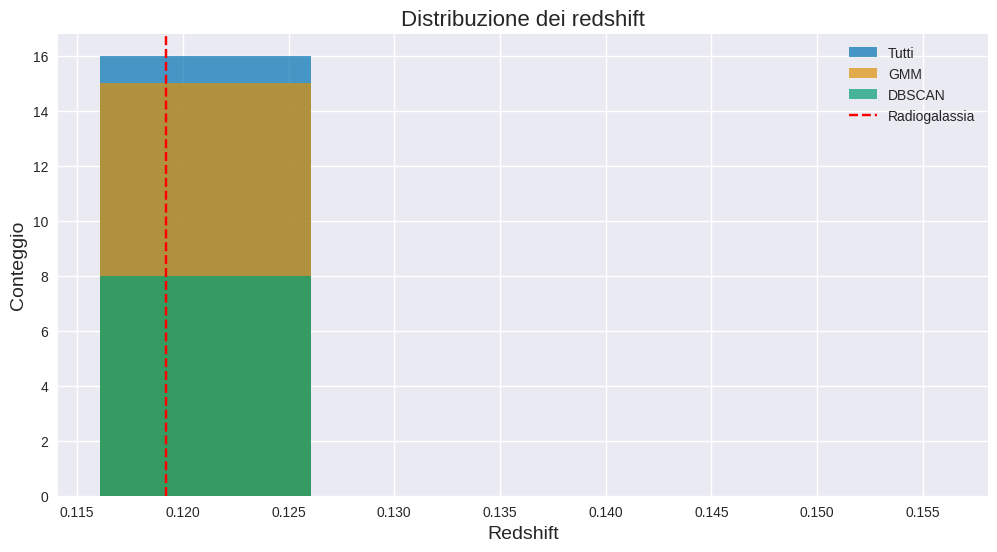

In [84]:
"""
## 6. Validazione con Redshift Spettroscopici

Utilizziamo i redshift spettroscopici disponibili per validare i risultati.
"""

# Assumiamo che la radiogalassia centrale abbia redshift z_RG
z_RG = 0.11922  # Sostituire con il valore reale

# Carica i redshift spettroscopici (se disponibili)
try:
    z_spec = galaxies['zsp'].values
    has_z_spec = ~np.isnan(z_spec)

    # Definisci i veri membri (entro delta_z < 0.01 dalla RG -> considero l'errore)
    true_members = np.abs(z_spec - z_RG) < 0.005

    # Confronta con i risultati del clustering
    gmm_predicted = np.zeros_like(true_members, dtype=bool)
    gmm_predicted[cluster_mask] = True

    dbscan_predicted = np.zeros_like(true_members, dtype=bool)
    dbscan_predicted[main_cluster_mask] = True

    # Metriche di performance
    def print_metrics(true, pred, method):
        cm = confusion_matrix(true, pred)
        precision = precision_score(true, pred)
        recall = recall_score(true, pred)

        print(f"\nMetriche per {method}:")
        print(f"Matrice di confusione:\n{cm}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall: {recall:.3f}")
        print(f"Purezza: {cm[1,1]/(cm[0,1]+cm[1,1]):.3f}")
        print(f"Completezza: {cm[1,1]/(cm[1,0]+cm[1,1]):.3f}")

    print_metrics(true_members, gmm_predicted, "GMM")
    print_metrics(true_members, dbscan_predicted, "DBSCAN")




    # Plot dei redshift
    plt.figure(figsize=(12, 6))
    z_min, z_max = np.nanmin(z_spec), 0.15
    bin_width = 0.01
    bins = np.arange(z_min, z_max + bin_width, bin_width)

    plt.hist(z_spec[has_z_spec], bins=bins, alpha=0.7, label='Tutti')
    plt.hist(z_spec[gmm_predicted & has_z_spec], bins=bins, alpha=0.7, label='GMM')
    plt.hist(z_spec[dbscan_predicted & has_z_spec], bins=bins, alpha=0.7, label='DBSCAN')


    plt.axvline(x=z_RG, color='r', linestyle='--', label='Radiogalassia')
    plt.xlabel('Redshift', fontsize=14)
    plt.ylabel('Conteggio', fontsize=14)
    plt.title('Distribuzione dei redshift', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

except KeyError:
    print("Nessun dato di redshift spettroscopico disponibile per la validazione.")



Approccio ibrido 1: GMM + DBSCAN

Cluster del target: 0
→ Numero membri nel cluster del target: 7
→ Ellittiche nel cluster del target: 7
Nessun altro cluster contiene galassie ellittiche
Numero di membri con approccio ibrido: 7


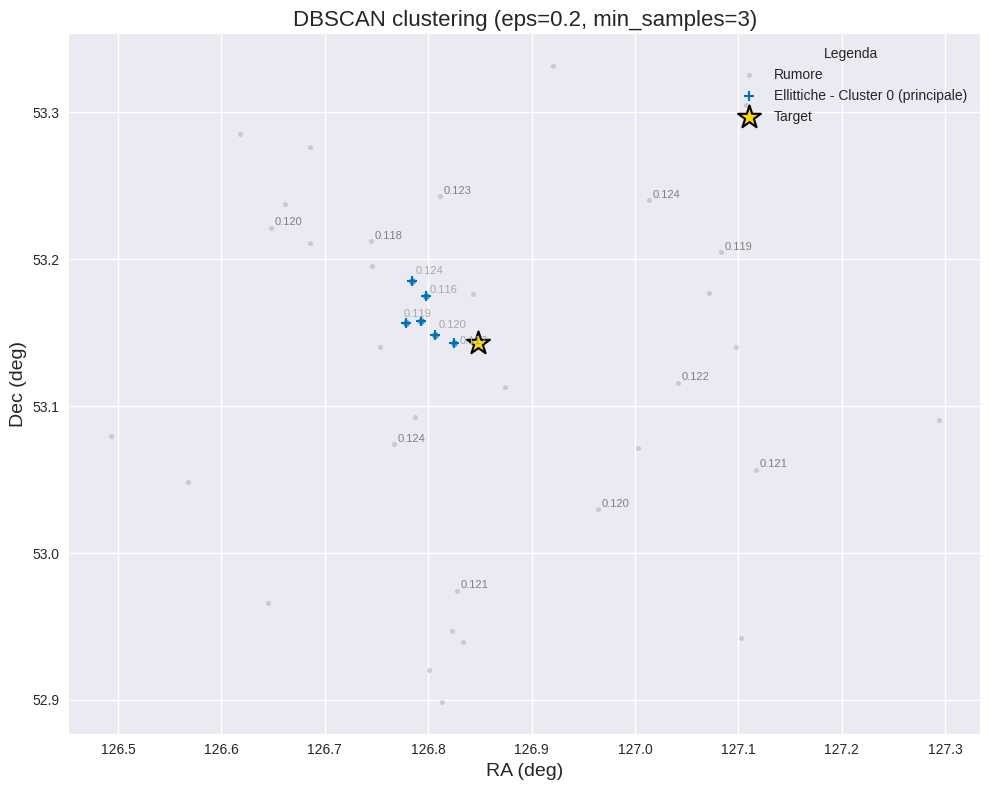

In [106]:
"""
## 7. Approccio Ibrido

Combiniamo GMM nel CMD e DBSCAN in RA/Dec per una selezione più robusta.
"""
# Modello 1: GMM in CMD seguito da DBSCAN in RA/Dec
print("\nApproccio ibrido 1: GMM + DBSCAN")

# Prendiamo i candidati dal GMM
gmm_candidates = galaxies[cluster_mask]

# Applica DBSCAN a questi candidati
hybrid_labels = apply_dbscan(gmm_candidates, eps=0.2, min_samples=3, ellipticals=ellipticals, target=target, show_redshifts=True)

# Gestione del caso in cui DBSCAN non trova cluster
if len(np.unique(hybrid_labels[hybrid_labels != -1])) == 0:
    print("DBSCAN non ha trovato cluster - usando tutti i candidati GMM")
    hybrid_members = gmm_candidates
else:
    # Trova l’indice del target nel DataFrame gmm_candidates
    try:
      target_idx_hybrid = gmm_candidates[gmm_candidates['SDSS9'] == target['SDSS9']].index[0]
      target_cluster_id = hybrid_labels[gmm_candidates.index.get_loc(target_idx_hybrid)]

      if target_cluster_id == -1:
          print("Il target è considerato rumore da DBSCAN nell'approccio ibrido.")
          hybrid_members = gmm_candidates.iloc[[]]  # Vuoto
      else:
          # Seleziona solo il cluster che contiene il target
          hybrid_cluster_mask = hybrid_labels == target_cluster_id
          hybrid_members = gmm_candidates[hybrid_cluster_mask]

    except IndexError:
      print("Il target non è stato trovato tra i candidati GMM.")
      hybrid_members = gmm_candidates.iloc[[]]  # Vuoto

print(f"Numero di membri con approccio ibrido: {len(hybrid_members)}")



Metriche per Approccio Ibrido:
Matrice di confusione:
[[801   2]
 [ 11   5]]
Precision: 0.714
Recall: 0.312
Purezza: 0.714
Completezza: 0.312


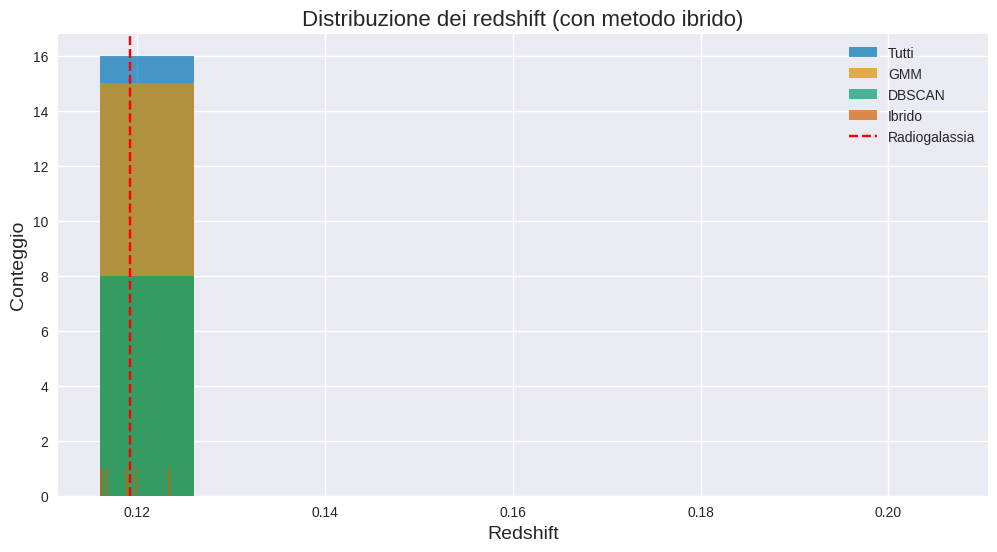

In [86]:
# Validazione con redshift spettroscopici per l'approccio ibrido
try:
    hybrid_predicted = np.zeros_like(true_members, dtype=bool)
    hybrid_predicted[hybrid_members.index] = True

    print_metrics(true_members, hybrid_predicted, "Approccio Ibrido")

    # Aggiungi l'istogramma anche per l'approccio ibrido
    plt.figure(figsize=(12, 6))
    z_min, z_max = np.nanmin(z_spec), 0.2
    bin_width = 0.01
    bins = np.arange(z_min, z_max + bin_width, bin_width)

    plt.hist(z_spec[has_z_spec], bins=bins, alpha=0.7, label='Tutti')
    plt.hist(z_spec[gmm_predicted & has_z_spec], bins=bins, alpha=0.7, label='GMM')
    plt.hist(z_spec[dbscan_predicted & has_z_spec], bins=bins, alpha=0.7, label='DBSCAN')
    plt.hist(z_spec[hybrid_predicted & has_z_spec], bins=30, alpha=0.7, label='Ibrido')

    plt.axvline(x=z_RG, color='r', linestyle='--', label='Radiogalassia')
    plt.xlabel('Redshift', fontsize=14)
    plt.ylabel('Conteggio', fontsize=14)
    plt.title('Distribuzione dei redshift (con metodo ibrido)', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"\nErrore durante la validazione dell’approccio ibrido: {e}")


In [89]:
"""
## Risultati Finali e Conclusioni

Sintetizziamo i risultati dei diversi approcci:
"""

# Tabella riassuntiva
results = pd.DataFrame({
    'Metodo': ['GMM ottimale', 'GMM 2 componenti', 'DBSCAN', 'GMM+DBSCAN'],
    'N_membri': [
        len(cluster_members),
        len(cluster_members_2),
        len(dbscan_cluster_members),
        len(hybrid_members),
    ]
})

print("\nRisultati comparativi:")
display(results)

# Salva i risultati
cluster_members.to_csv('membri_cluster_gmm.csv', index=False)
hybrid_members.to_csv('membri_cluster_ibrido.csv', index=False)



"""
## Conclusioni

1. Il metodo GMM nel diagramma CMD è efficace per identificare la red sequence.
2. L'approccio ibrido (GMM + DBSCAN) fornisce una selezione più pulita combinando informazioni fotometriche e spaziali.
4. La validazione con redshift spettroscopici è cruciale per valutare la qualità della selezione.

Per ulteriori analisi:
- Sperimentare con diversi parametri per DBSCAN
- Provare altri algoritmi di clustering (es. HDBSCAN)
- Includere altre bande fotometriche per migliorare la separazione
"""


Risultati comparativi:


Metodo  N_membri
0      GMM ottimale        40
1  GMM 2 componenti       341
2            DBSCAN       191
3        GMM+DBSCAN         7

"\n## Conclusioni\n\n1. Il metodo GMM nel diagramma CMD è efficace per identificare la red sequence.\n2. L'approccio ibrido (GMM + DBSCAN) fornisce una selezione più pulita combinando informazioni fotometriche e spaziali.\n4. La validazione con redshift spettroscopici è cruciale per valutare la qualità della selezione.\n\nPer ulteriori analisi:\n- Sperimentare con diversi parametri per DBSCAN\n- Provare altri algoritmi di clustering (es. HDBSCAN)\n- Includere altre bande fotometriche per migliorare la separazione\n"